In [ ]:
%%capture
!pip install datasets
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset, load_from_disk
import pickle

# Load Dataset

Includes image embeddings.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

DRIVE_BASE_PATH = os.path.join("/content/drive/My Drive", "MIT 6.8610")

Mounted at /content/drive


In [ ]:
def load_dataset_from_colab(dataset_name, data_folder):
    drive_base_folder = "MIT 6.8610"

    dataset_path = os.path.join(
            DRIVE_BASE_PATH,
            f"{data_folder}/{dataset_name}"
    )
    return load_from_disk(dataset_path)

In [ ]:
# Load data
# train_data_name = "train_data_10000_1701296984.8426719.hf" # 10,000 datapoints
train_data_name = "train_data_100000_1701475168.5889082.hf" # 100,000 datapoints
train_data = load_dataset_from_colab(train_data_name, data_folder="Train Data Agg")

In [ ]:
train_data = train_data.filter(lambda item: item["image_embedding"] is not None)
train_data

Dataset({
    features: ['image_url', 'caption', 'image_embedding'],
    num_rows: 81980
})

# Modeling

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data

import re
import string
import random

import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime

from sklearn.decomposition import PCA

## Hyper-parameters

In [ ]:
# Constants
IMAGE_EMBEDDING_SIZE = 768

# Hyper-parameters
FREQUENCY_THRESHOLD = 5
WINDOW_SIZE = 5
WORD_EMBEDDING_SIZE = 100
BATCH_SIZE = 20
N_EPOCHS = 20

# For new image-enhanced model only
IMAGE_PCA_SIZE = 32

## Tokenization and N-Gram Helpers

In [ ]:
def show_similar_words(tokenizer, reps, tokens):
    reps = reps / (np.sqrt((reps ** 2).sum(axis=1, keepdims=True)))
    #for i, (word, token) in enumerate(tokenizer.word_to_token.items()):
    for token in tokens:
        word = tokenizer.token_to_word[token]
        rep = reps[token, :]
        sims = ((reps - rep) ** 2).sum(axis=1)
        nearest = np.argsort(sims)
        print(word, token)
        for j in nearest[1:6]:
            print(" ", tokenizer.token_to_word[j], "%.3f" % sims[j])

class Tokenizer:
  def __init__(self, min_occur=FREQUENCY_THRESHOLD):
    self.word_to_token = {}
    self.token_to_word = {}
    self.word_count = {}

    self.word_to_token['<unk>'] = 0
    self.token_to_word[0] = '<unk>'
    self.vocab_size = 1

    self.min_occur = min_occur

  def fit(self, corpus):
    for caption in corpus:
      caption = caption.strip().lower()
      words = re.findall(r"[\w']+|[.,!?;]", caption)
      for word in words:
          if word not in self.word_count:
              self.word_count[word] = 0
          self.word_count[word] += 1

    for caption in corpus:
      caption = caption.strip().lower()
      words = re.findall(r"[\w']+|[.,!?;]", caption)
      for word in words:
        if self.word_count[word] < self.min_occur:
          continue
        if word in self.word_to_token:
          continue
        self.word_to_token[word] = self.vocab_size
        self.token_to_word[self.vocab_size] = word
        self.vocab_size += 1

  def tokenize(self, corpus):
    tokenized_corpus = []
    for review in corpus:
      review = review.strip().lower()
      words = re.findall(r"[\w']+|[.,!?;]", review)
      tokenized_review = []
      for word in words:
        if word not in self.word_to_token:
          tokenized_review.append(0)
        else:
          tokenized_review.append(self.word_to_token[word])
      tokenized_corpus.append(tokenized_review)
    return tokenized_corpus

  def de_tokenize(self, tokenized_corpus):
    corpus = []
    for tokenized_review in tokenized_corpus:
      review = []
      for token in tokenized_review:
        review.append(self.token_to_word[token])
      corpus.append(" ".join(review))
    return corpus

def get_ngrams(tokenized_caption, window_size, pad_idx, image_embedding=None):
    ngrams = []
    for j, word in enumerate(tokenized_caption):
        min_ind = max(0, j-window_size)
        max_ind = min(len(tokenized_caption), j+window_size+1)
        ctx = np.zeros(2 * window_size, dtype=np.int64) + pad_idx
        for ik, k in enumerate(range(min_ind, j)):
            ctx[ik] = tokenized_caption[k]
        for ik, k in enumerate(range(j+1, max_ind)):
            ctx[window_size+ik] = tokenized_caption[k]

        if image_embedding is not None:
          ngrams.append((ctx, image_embedding, tokenized_caption[j]))
        else:
          ngrams.append((ctx, tokenized_caption[j]))
    return ngrams

## Image-Enhanced Word2Vec Model (first attempt)

In [ ]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, embedding_size, image_embedding_size, LAMBDA = 0):
        super(CustomLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=True)

        self.embedding_size = embedding_size
        self.image_embedding_size = image_embedding_size
        self.LAMBDA = LAMBDA
        self.weight = self.linear.weight
        # LAMBDA=1 weights word and image embeddings equally;
        # 0 only weights word embeddings; inf only weights image embeddings

    def forward(self, x):
        # Assuming x is a 2D tensor with shape (batch_size, in_features)
        # Get the original weights and biases
        original_weights = self.linear.weight
        original_biases = self.linear.bias

        # Manipulate weights (for example, multiply each weight by its column index)
        # modified_weights = original_weights * torch.arange(original_weights.size(1)).float().view(1, -1)

        multiplicator = (torch.tensor([1 / (1 + self.LAMBDA)] * self.embedding_size + [self.LAMBDA / (1 + self.LAMBDA)] * self.image_embedding_size).float().view(1, -1)).to('cuda')
        modified_weights = (original_weights * multiplicator).to('cuda')

        # Apply the linear transformation with modified weights and biases
        result = torch.matmul(x, modified_weights.t()) + original_biases

        return result


class ImageEnhancedWord2VecModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, padding_idx, LAMBDA):
        super().__init__()
        print("Vocab size:", vocab_size)
        self.padded_size = vocab_size + 1 # padding for constant length

        # Embedding layer for context words
        self.input_embedding = nn.Embedding(self.padded_size, embedding_size, padding_idx=padding_idx).to('cuda') # run on colab gpu

        # Embedding layer for target words
        # self.output_embedding = nn.Linear(embedding_size + image_embedding_size, vocab_size).to('cuda')

        self.output_embedding = CustomLinear(embedding_size + IMAGE_EMBEDDING_SIZE, vocab_size, embedding_size, IMAGE_EMBEDDING_SIZE, LAMBDA).to('cuda')

    def forward(self, context, image_embedding):
        # out put vector dotted summed input context vectors/context window size

         # Embed context words
        context_embeddings = self.input_embedding(context)  # Shape: n_batch x n_context x embedding_size

        # Sum the embeddings along the context dimension
        summed_context = context_embeddings.sum(dim=1)  # Shape: n_batch x embedding_size
        combined_context = torch.cat((summed_context, image_embedding), dim=1)

        predicted_scores = self.output_embedding(combined_context)

        return predicted_scores


In [ ]:
def learn_reps_image_enhanced_word2vec(captions, image_embeds, window_size, rep_size, n_epochs, n_batch, LAMBDA):
    # This method takes in a corpus of training sentences. It returns a matrix of
    # word embeddings with the same structure as used in the previous section of
    # the assignment. (You can extract this matrix from the parameters of the
    # Word2VecModel.)

    tokenizer = Tokenizer()
    tokenizer.fit(captions)
    tokenized_captions = tokenizer.tokenize(captions)
    ngrams = []
    pad_idx = tokenizer.vocab_size

    for i, cap in enumerate(tokenized_captions):
      try:
        ngrams_i = get_ngrams(cap, window_size, pad_idx, image_embedding=torch.tensor(image_embeds[i]))
        ngrams.extend(ngrams_i)
      except:
        continue

    device = torch.device('cuda')  # run on colab gpu
    model = ImageEnhancedWord2VecModel(tokenizer.vocab_size, rep_size, pad_idx, LAMBDA).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)

    loader = torch_data.DataLoader(ngrams, batch_size=n_batch, shuffle=True)

    loss_fn = nn.CrossEntropyLoss()

    losses = []  # Potentially useful for debugging (loss should go down!)
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0

        for context, image_embedding, label in loader:
            context=context.to(device)
            image_embedding = image_embedding.to(device)
            label = label.to(device)
            preds = model(context, image_embedding)

            loss = loss_fn(preds,label)
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item()
        losses.append(epoch_loss)
        print(f"epoch : {epoch}, epoch_loss = {epoch_loss}")

    epochs = range(1, len(losses) + 1)

    # Create a line plot of losses
    plt.plot(epochs, losses, marker='o', linestyle='-')
    plt.title(f'Loss: n_samples={len(train_data)}, lambda={LAMBDA}')
    plt.xlabel('Epochs or Iterations')
    plt.ylabel('Loss')
    plt.grid(True)

    # Show the plot
    plt.show()
    embedding_matrix = model.input_embedding.weight.cpu().detach().numpy()[:tokenizer.vocab_size,:]

    # Download the embeddings and tokenization for future use
    current_time = datetime.now().strftime("%m-%d-%H:%M")
    full_file_path = os.path.join(DRIVE_BASE_PATH, f"Result Embeddings/Image-Enhanced Model/w2v_enhanced_embeddings_{len(train_data)}_samples_lambda_{LAMBDA}")
    with open(full_file_path, 'wb') as file:
      data = {"embeddings": embedding_matrix, "word_to_token": tokenizer.word_to_token}
      pickle.dump(data, file)

    return model, embedding_matrix, tokenizer.word_to_token

In [ ]:
models_enhanced, reps_enhanced, word_to_token_enhanced = {}, {}, {}

LAMBDAS_TO_TRY = [0, 0.25, 1]
LAMBDAS_TO_TRY = [0.1]
LAMBDAS_TO_TRY = [1]

bulding model for LAM = 1
Vocab size: 8130


  5%|▌         | 1/20 [01:40<31:50, 100.54s/it]

epoch : 0, epoch_loss = 205297.55708098412


 10%|█         | 2/20 [03:19<29:55, 99.76s/it] 

epoch : 1, epoch_loss = 165955.19229662418


 15%|█▌        | 3/20 [04:58<28:11, 99.49s/it]

epoch : 2, epoch_loss = 151018.74868118763


 20%|██        | 4/20 [06:37<26:28, 99.27s/it]

epoch : 3, epoch_loss = 141755.3447227478


 25%|██▌       | 5/20 [08:17<24:48, 99.24s/it]

epoch : 4, epoch_loss = 135363.6887960434


 30%|███       | 6/20 [09:56<23:08, 99.19s/it]

epoch : 5, epoch_loss = 130479.49818742275


 35%|███▌      | 7/20 [11:35<21:29, 99.17s/it]

epoch : 6, epoch_loss = 126534.76422667503


 40%|████      | 8/20 [13:13<19:48, 99.03s/it]

epoch : 7, epoch_loss = 123311.67099940777


 45%|████▌     | 9/20 [14:53<18:10, 99.18s/it]

epoch : 8, epoch_loss = 120660.48837918043


 50%|█████     | 10/20 [16:32<16:30, 99.09s/it]

epoch : 9, epoch_loss = 118487.61268687248


 55%|█████▌    | 11/20 [18:11<14:52, 99.19s/it]

epoch : 10, epoch_loss = 116491.10988152027


 60%|██████    | 12/20 [19:51<13:14, 99.30s/it]

epoch : 11, epoch_loss = 114834.69659245014


 65%|██████▌   | 13/20 [21:30<11:34, 99.27s/it]

epoch : 12, epoch_loss = 113334.91475975513


 70%|███████   | 14/20 [23:09<09:54, 99.16s/it]

epoch : 13, epoch_loss = 112008.27359008789


 75%|███████▌  | 15/20 [24:48<08:15, 99.11s/it]

epoch : 14, epoch_loss = 110857.12300473452


 80%|████████  | 16/20 [26:27<06:36, 99.09s/it]

epoch : 15, epoch_loss = 109803.9779920578


 85%|████████▌ | 17/20 [28:07<04:57, 99.27s/it]

epoch : 16, epoch_loss = 108914.7253485918


 90%|█████████ | 18/20 [29:46<03:18, 99.31s/it]

epoch : 17, epoch_loss = 108078.10131794214


 95%|█████████▌| 19/20 [31:25<01:39, 99.31s/it]

epoch : 18, epoch_loss = 107264.13471961021


100%|██████████| 20/20 [33:05<00:00, 99.28s/it]

epoch : 19, epoch_loss = 106504.4862024188


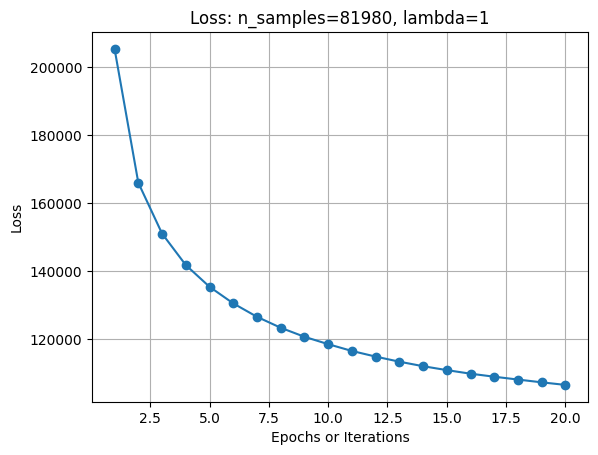

In [ ]:
for LAM in LAMBDAS_TO_TRY:
    print(f'bulding model for LAM = {LAM}')
    model_image_enhanced_word2vec, reps_image_enhanced_word2vec, word_to_token_image_enhanced  = learn_reps_image_enhanced_word2vec(
        train_data["caption"], train_data["image_embedding"], WINDOW_SIZE, rep_size=WORD_EMBEDDING_SIZE,
        n_epochs=N_EPOCHS, n_batch=BATCH_SIZE, LAMBDA=LAM
    )
    models_enhanced[LAM] = model_image_enhanced_word2vec
    reps_enhanced[LAM] = reps_image_enhanced_word2vec
    word_to_token_enhanced[LAM] = word_to_token_image_enhanced

## WIELD: New Image-Enhanced Model

This model has two training objectives: predict the masked word, and predict a PCA-projected version of the image embedding associated with the caption. The only input to the model is the context window around the masked word.

In [ ]:
class NewImageEnhancedWord2VecModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, image_pca_size, padding_idx):
        super().__init__()
        print(vocab_size, padding_idx)
        self.padded_size = vocab_size + 1 # padding for constant length

        # Embedding layer for context words
        self.input_embedding = nn.Embedding(self.padded_size, embedding_size, padding_idx=padding_idx).to('cuda') # run on colab gpu

        # Embedding layer for target words
        # self.output_embedding = nn.Linear(embedding_size + image_embedding_size, vocab_size).to('cuda')

        self.output_embedding = nn.Linear(embedding_size, vocab_size).to('cuda')
        self.image_projection = nn.Linear(embedding_size, image_pca_size).to('cuda')

    def forward(self, context):
        # Embed context words
        context_embeddings = self.input_embedding(context)  # Shape: n_batch x n_context x embedding_size

        # Sum the embeddings along the context dimension
        summed_context = context_embeddings.sum(dim=1)  # Shape: n_batch x embedding_size

        predicted_scores = self.output_embedding(summed_context)
        predicted_image_embedding = self.image_projection(summed_context)

        return predicted_scores, predicted_image_embedding

In [ ]:
def custom_loss(output, target, gamma=10):
  predicted_word_logits, predicted_image_embedding = output
  actual_word, actual_image_embedding_pca = target

  cross_entropy_loss = nn.CrossEntropyLoss()
  mse_loss = nn.MSELoss()

  # convert all to float
  predicted_word_logits = predicted_word_logits.float()
  actual_word = actual_word.long()
  predicted_image_embedding = predicted_image_embedding.float()
  actual_image_embedding_pca = actual_image_embedding_pca.float()

  loss_word = cross_entropy_loss(predicted_word_logits, actual_word)
  loss_img = mse_loss(predicted_image_embedding, actual_image_embedding_pca)

  # print(f"Cross entropy loss for predicted word: {loss_word}")
  # print(f"MSE loss for predicted img: {loss_img}")

  return (1/(1+gamma)) * loss_word + (gamma/(1+gamma)) * loss_img

In [ ]:
def learn_reps_new_image_enhanced_word2vec(captions, image_embeds, window_size, rep_size, image_pca_size, loss_gamma, n_epochs, n_batch):
    # This method takes in a corpus of training sentences. It returns a matrix of
    # word embeddings with the same structure as used in the previous section of
    # the assignment. (You can extract this matrix from the parameters of the
    # Word2VecModel.)
    print(len(image_embeds))
    tokenizer = Tokenizer()
    tokenizer.fit(captions)
    tokenized_captions = tokenizer.tokenize(captions)
    ngrams = []
    pad_idx = tokenizer.vocab_size

    pca = PCA(n_components=image_pca_size)
    image_embeds_pca = pca.fit_transform(np.array(image_embeds))

    for i, cap in enumerate(tokenized_captions):
      try:
        ngrams_i = get_ngrams(cap, window_size, pad_idx, image_embedding=torch.tensor(image_embeds_pca[i, :]))
        ngrams.extend(ngrams_i)
      except:
        continue

    device = torch.device('cuda')  # run on colab gpu
    model = NewImageEnhancedWord2VecModel(tokenizer.vocab_size, rep_size, image_pca_size, pad_idx).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)

    loader = torch_data.DataLoader(ngrams, batch_size=n_batch, shuffle=True)

    losses = []  # Potentially useful for debugging (loss should go down!)
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0

        for context, image_embedding_pca, label in loader:
            context=context.to(device)
            image_embedding_pca = image_embedding_pca.to(device)
            label = label.to(device)
            output = model(context)
            target = (label, image_embedding_pca)

            loss = custom_loss(output, target, gamma=loss_gamma)
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item()
        losses.append(epoch_loss)
        print(f"epoch : {epoch}, epoch_loss = {epoch_loss}")

    epochs = range(1, len(losses) + 1)

    # Create a line plot of losses
    plt.plot(epochs, losses, marker='o', linestyle='-')
    plt.title(f'Loss (new model): n_samples={len(train_data)}')
    plt.xlabel('Epochs or Iterations')
    plt.ylabel('Loss')
    plt.grid(True)

    # Show the plot
    plt.show()
    embedding_matrix = model.input_embedding.weight.cpu().detach().numpy()[:tokenizer.vocab_size,:]

    # Download the embeddings and tokenization for future use
    current_time = datetime.now().strftime("%m-%d-%H:%M")
    full_file_path = os.path.join(DRIVE_BASE_PATH, f"Result Embeddings/Image-Enhanced Model/new_w2v_enhanced_embeddings_{len(train_data)}_samples_{loss_gamma}_gamma_{WINDOW_SIZE}_windowsize_{current_time}")
    with open(full_file_path, 'wb') as file:
      data = {"embeddings": embedding_matrix, "word_to_token": tokenizer.word_to_token}
      pickle.dump(data, file)

    return model, embedding_matrix, tokenizer.word_to_token

In [ ]:
# Second run to try with epoch 1 to get order of magnitude
model_new_image_enhanced_word2vec, reps_new_image_enhanced_word2vec, word_to_token_new_image_enhanced  = learn_reps_new_image_enhanced_word2vec(
        train_data["caption"], train_data["image_embedding"], WINDOW_SIZE, rep_size=WORD_EMBEDDING_SIZE, image_pca_size=IMAGE_PCA_SIZE,
        loss_gamma=10, n_epochs=1, n_batch=BATCH_SIZE
    )

Based on this we should try 0 (baseline), 10, 50, 250

8130 8130


  5%|▌         | 1/20 [01:37<30:44, 97.06s/it]

epoch : 0, epoch_loss = 225873.87052083015


 10%|█         | 2/20 [03:13<28:59, 96.62s/it]

epoch : 1, epoch_loss = 201492.4703192711


 15%|█▌        | 3/20 [04:49<27:22, 96.61s/it]

epoch : 2, epoch_loss = 193235.64075517654


 20%|██        | 4/20 [06:26<25:45, 96.59s/it]

epoch : 3, epoch_loss = 186764.69103968143


 25%|██▌       | 5/20 [08:03<24:08, 96.60s/it]

epoch : 4, epoch_loss = 182152.2814553976


 30%|███       | 6/20 [09:39<22:30, 96.47s/it]

epoch : 5, epoch_loss = 179238.3387016058


 35%|███▌      | 7/20 [11:15<20:53, 96.45s/it]

epoch : 6, epoch_loss = 176914.23240470886


 40%|████      | 8/20 [12:52<19:18, 96.51s/it]

epoch : 7, epoch_loss = 175168.90187728405


 45%|████▌     | 9/20 [14:29<17:43, 96.68s/it]

epoch : 8, epoch_loss = 173698.52360153198


 50%|█████     | 10/20 [16:06<16:07, 96.77s/it]

epoch : 9, epoch_loss = 172461.7478145361


 55%|█████▌    | 11/20 [17:43<14:31, 96.79s/it]

epoch : 10, epoch_loss = 171464.09610319138


 60%|██████    | 12/20 [19:19<12:53, 96.68s/it]

epoch : 11, epoch_loss = 170541.32324779034


 65%|██████▌   | 13/20 [20:55<11:15, 96.51s/it]

epoch : 12, epoch_loss = 169869.0839960575


 70%|███████   | 14/20 [22:31<09:37, 96.27s/it]

epoch : 13, epoch_loss = 169242.3644579649


 75%|███████▌  | 15/20 [24:06<08:00, 96.01s/it]

epoch : 14, epoch_loss = 168628.49802291393


 80%|████████  | 16/20 [25:43<06:24, 96.19s/it]

epoch : 15, epoch_loss = 168153.5798267126


 85%|████████▌ | 17/20 [27:19<04:48, 96.26s/it]

epoch : 16, epoch_loss = 167744.02740836143


 90%|█████████ | 18/20 [28:56<03:12, 96.39s/it]

epoch : 17, epoch_loss = 167390.06971538067


 95%|█████████▌| 19/20 [30:33<01:36, 96.49s/it]

epoch : 18, epoch_loss = 167032.38281095028


100%|██████████| 20/20 [32:09<00:00, 96.49s/it]

epoch : 19, epoch_loss = 166730.93310546875


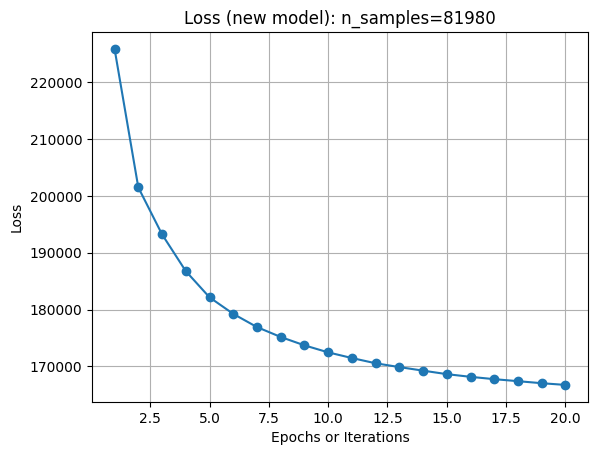

In [ ]:
model_new_image_enhanced_word2vec, reps_new_image_enhanced_word2vec, word_to_token_new_image_enhanced  = learn_reps_new_image_enhanced_word2vec(
        train_data["caption"], train_data["image_embedding"], WINDOW_SIZE, rep_size=WORD_EMBEDDING_SIZE, image_pca_size=IMAGE_PCA_SIZE,
        loss_gamma=0, n_epochs=N_EPOCHS, n_batch=BATCH_SIZE
)

2003 2003


  5%|▌         | 1/20 [00:09<03:09,  9.97s/it]

epoch : 0, epoch_loss = 588.5425271689892


 10%|█         | 2/20 [00:18<02:47,  9.29s/it]

epoch : 1, epoch_loss = 483.04631746560335


 15%|█▌        | 3/20 [00:28<02:38,  9.33s/it]

epoch : 2, epoch_loss = 462.66422321647406


 20%|██        | 4/20 [00:37<02:28,  9.26s/it]

epoch : 3, epoch_loss = 450.169902831316


 25%|██▌       | 5/20 [00:46<02:18,  9.23s/it]

epoch : 4, epoch_loss = 441.39873430877924


 30%|███       | 6/20 [00:55<02:09,  9.24s/it]

epoch : 5, epoch_loss = 434.8124156370759


 35%|███▌      | 7/20 [01:04<01:57,  9.08s/it]

epoch : 6, epoch_loss = 429.33317594230175


 40%|████      | 8/20 [01:14<01:51,  9.29s/it]

epoch : 7, epoch_loss = 425.011383831501


 45%|████▌     | 9/20 [01:24<01:44,  9.51s/it]

epoch : 8, epoch_loss = 421.66560381650925


 50%|█████     | 10/20 [01:32<01:32,  9.24s/it]

epoch : 9, epoch_loss = 418.78194569051266


 55%|█████▌    | 11/20 [01:42<01:23,  9.25s/it]

epoch : 10, epoch_loss = 416.51364212855697


 60%|██████    | 12/20 [01:51<01:14,  9.31s/it]

epoch : 11, epoch_loss = 414.66018545255065


 65%|██████▌   | 13/20 [02:00<01:04,  9.15s/it]

epoch : 12, epoch_loss = 413.250048533082


 70%|███████   | 14/20 [02:09<00:55,  9.24s/it]

epoch : 13, epoch_loss = 412.1087972819805


 75%|███████▌  | 15/20 [02:18<00:46,  9.20s/it]

epoch : 14, epoch_loss = 410.9355371110141


 80%|████████  | 16/20 [02:28<00:36,  9.17s/it]

epoch : 15, epoch_loss = 410.2275638692081


 85%|████████▌ | 17/20 [02:38<00:28,  9.53s/it]

epoch : 16, epoch_loss = 409.5985742993653


 90%|█████████ | 18/20 [02:47<00:18,  9.40s/it]

epoch : 17, epoch_loss = 409.067695081234


 95%|█████████▌| 19/20 [02:56<00:09,  9.32s/it]

epoch : 18, epoch_loss = 408.3832482881844


100%|██████████| 20/20 [03:06<00:00,  9.31s/it]

epoch : 19, epoch_loss = 408.1870868355036


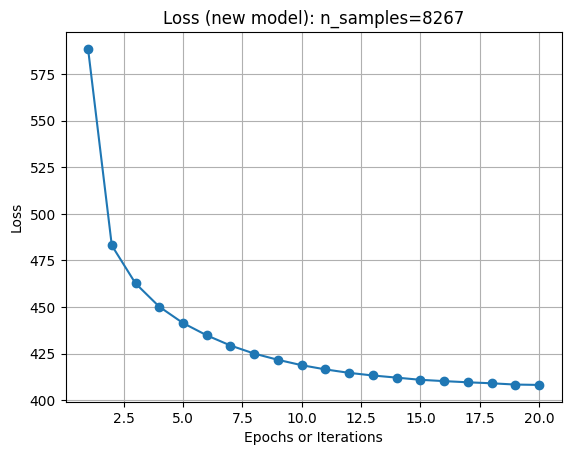

In [ ]:
model_new_image_enhanced_word2vec, reps_new_image_enhanced_word2vec, word_to_token_new_image_enhanced  = learn_reps_new_image_enhanced_word2vec(
        train_data["caption"], train_data["image_embedding"], WINDOW_SIZE, rep_size=WORD_EMBEDDING_SIZE, image_pca_size=IMAGE_PCA_SIZE,
        loss_gamma=10000, n_epochs=N_EPOCHS, n_batch=BATCH_SIZE
    )

In [ ]:
model_new_image_enhanced_word2vec, reps_new_image_enhanced_word2vec, word_to_token_new_image_enhanced  = learn_reps_new_image_enhanced_word2vec(
        train_data["caption"], train_data["image_embedding"], WINDOW_SIZE, rep_size=WORD_EMBEDDING_SIZE, image_pca_size=IMAGE_PCA_SIZE,
        loss_gamma=10, n_epochs=N_EPOCHS, n_batch=BATCH_SIZE
)

8130 8130


  5%|▌         | 1/20 [01:35<30:18, 95.70s/it]

epoch : 0, epoch_loss = 9041.005903586745


 10%|█         | 2/20 [03:11<28:45, 95.83s/it]

epoch : 1, epoch_loss = 8154.632699981332


 15%|█▌        | 3/20 [04:47<27:07, 95.72s/it]

epoch : 2, epoch_loss = 7881.47587479651


 20%|██        | 4/20 [06:22<25:29, 95.62s/it]

epoch : 3, epoch_loss = 7694.418618693948


 25%|██▌       | 5/20 [07:58<23:54, 95.63s/it]

epoch : 4, epoch_loss = 7569.58171851933


 30%|███       | 6/20 [09:33<22:16, 95.48s/it]

epoch : 5, epoch_loss = 7483.858659423888


 35%|███▌      | 7/20 [11:08<20:40, 95.40s/it]

epoch : 6, epoch_loss = 7423.637261107564


 40%|████      | 8/20 [12:43<19:01, 95.17s/it]

epoch : 7, epoch_loss = 7378.7018038108945


 45%|████▌     | 9/20 [14:18<17:26, 95.13s/it]

epoch : 8, epoch_loss = 7344.063286721706


 50%|█████     | 10/20 [15:53<15:52, 95.23s/it]

epoch : 9, epoch_loss = 7315.528618790209


 55%|█████▌    | 11/20 [17:29<14:17, 95.23s/it]

epoch : 10, epoch_loss = 7292.854124099016


 60%|██████    | 12/20 [19:04<12:42, 95.31s/it]

epoch : 11, epoch_loss = 7275.579647354782


 65%|██████▌   | 13/20 [20:40<11:07, 95.43s/it]

epoch : 12, epoch_loss = 7259.952635489404


 70%|███████   | 14/20 [22:15<09:32, 95.40s/it]

epoch : 13, epoch_loss = 7248.076304063201


 75%|███████▌  | 15/20 [23:51<07:57, 95.48s/it]

epoch : 14, epoch_loss = 7237.150878451765


 80%|████████  | 16/20 [25:26<06:22, 95.53s/it]

epoch : 15, epoch_loss = 7227.477270156145


 85%|████████▌ | 17/20 [27:02<04:46, 95.50s/it]

epoch : 16, epoch_loss = 7219.650323227048


 90%|█████████ | 18/20 [28:37<03:10, 95.39s/it]

epoch : 17, epoch_loss = 7213.167070902884


 95%|█████████▌| 19/20 [30:12<01:35, 95.23s/it]

epoch : 18, epoch_loss = 7206.263150624931


100%|██████████| 20/20 [31:48<00:00, 95.42s/it]

epoch : 19, epoch_loss = 7201.725168928504


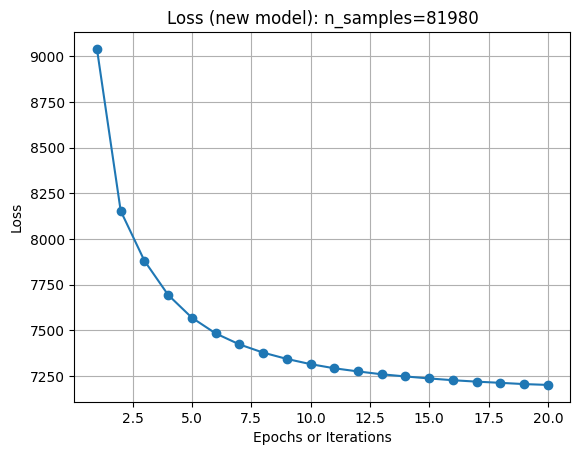

In [ ]:
model_new_image_enhanced_word2vec, reps_new_image_enhanced_word2vec, word_to_token_new_image_enhanced  = learn_reps_new_image_enhanced_word2vec(
        train_data["caption"], train_data["image_embedding"], WINDOW_SIZE, rep_size=WORD_EMBEDDING_SIZE, image_pca_size=IMAGE_PCA_SIZE,
        loss_gamma=50, n_epochs=N_EPOCHS, n_batch=BATCH_SIZE
)

In [ ]:
model_new_image_enhanced_word2vec, reps_new_image_enhanced_word2vec, word_to_token_new_image_enhanced  = learn_reps_new_image_enhanced_word2vec(
        train_data["caption"], train_data["image_embedding"], WINDOW_SIZE, rep_size=WORD_EMBEDDING_SIZE, image_pca_size=IMAGE_PCA_SIZE,
        loss_gamma=250, n_epochs=N_EPOCHS, n_batch=BATCH_SIZE
)

In [ ]:
len(train_data)

81980

81980
8130 8130


  5%|▌         | 1/20 [01:33<29:42, 93.82s/it]

epoch : 0, epoch_loss = 4610.286973208189


 10%|█         | 2/20 [03:06<27:52, 92.94s/it]

epoch : 1, epoch_loss = 4169.394227471203


 15%|█▌        | 3/20 [04:37<26:11, 92.41s/it]

epoch : 2, epoch_loss = 4065.345493108034


 20%|██        | 4/20 [06:09<24:33, 92.08s/it]

epoch : 3, epoch_loss = 4017.3501091487706


 25%|██▌       | 5/20 [07:41<23:02, 92.19s/it]

epoch : 4, epoch_loss = 3991.7750182673335


 30%|███       | 6/20 [09:13<21:30, 92.15s/it]

epoch : 5, epoch_loss = 3977.20877129212


 35%|███▌      | 7/20 [10:45<19:56, 92.00s/it]

epoch : 6, epoch_loss = 3968.279573585838


 40%|████      | 8/20 [12:16<18:20, 91.72s/it]

epoch : 7, epoch_loss = 3963.047956239432


 45%|████▌     | 9/20 [13:48<16:49, 91.77s/it]

epoch : 8, epoch_loss = 3958.636987324804


 50%|█████     | 10/20 [15:20<15:16, 91.68s/it]

epoch : 9, epoch_loss = 3956.2463997863233


 55%|█████▌    | 11/20 [16:51<13:44, 91.62s/it]

epoch : 10, epoch_loss = 3953.7964269556105


 60%|██████    | 12/20 [18:23<12:13, 91.63s/it]

epoch : 11, epoch_loss = 3951.9689794927835


 65%|██████▌   | 13/20 [19:55<10:41, 91.68s/it]

epoch : 12, epoch_loss = 3950.4339240193367


 70%|███████   | 14/20 [21:27<09:11, 91.84s/it]

epoch : 13, epoch_loss = 3949.3576947934926


 75%|███████▌  | 15/20 [22:59<07:40, 92.01s/it]

epoch : 14, epoch_loss = 3947.7237684465945


 80%|████████  | 16/20 [24:32<06:09, 92.27s/it]

epoch : 15, epoch_loss = 3946.850798651576


 85%|████████▌ | 17/20 [26:06<04:38, 92.84s/it]

epoch : 16, epoch_loss = 3946.03961231187


 90%|█████████ | 18/20 [27:41<03:06, 93.46s/it]

epoch : 17, epoch_loss = 3944.8326934613287


 95%|█████████▌| 19/20 [29:16<01:33, 93.74s/it]

epoch : 18, epoch_loss = 3944.598565682769


100%|██████████| 20/20 [30:49<00:00, 92.46s/it]

epoch : 19, epoch_loss = 3944.090611677617


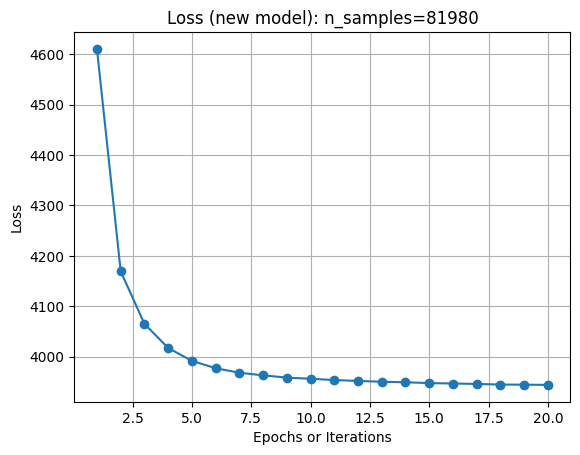

In [ ]:
# 10k gamma w/ 100k samples
model_new_image_enhanced_word2vec, reps_new_image_enhanced_word2vec, word_to_token_new_image_enhanced  = learn_reps_new_image_enhanced_word2vec(
        train_data["caption"], train_data["image_embedding"], WINDOW_SIZE, rep_size=WORD_EMBEDDING_SIZE, image_pca_size=IMAGE_PCA_SIZE,
        loss_gamma=10000, n_epochs=N_EPOCHS, n_batch=BATCH_SIZE
)

81980
8130 8130


  5%|▌         | 1/20 [01:30<28:42, 90.66s/it]

epoch : 0, epoch_loss = 26661.062573581934


 10%|█         | 2/20 [03:00<27:00, 90.04s/it]

epoch : 1, epoch_loss = 23495.661008119583


 15%|█▌        | 3/20 [04:29<25:24, 89.65s/it]

epoch : 2, epoch_loss = 22271.62568885088


 20%|██        | 4/20 [05:58<23:47, 89.22s/it]

epoch : 3, epoch_loss = 21365.97388613224


 25%|██▌       | 5/20 [07:26<22:16, 89.11s/it]

epoch : 4, epoch_loss = 20729.64339146018


 30%|███       | 6/20 [08:55<20:45, 89.00s/it]

epoch : 5, epoch_loss = 20235.645224034786


 35%|███▌      | 7/20 [10:24<19:16, 88.98s/it]

epoch : 6, epoch_loss = 19880.007339179516


 40%|████      | 8/20 [11:53<17:46, 88.92s/it]

epoch : 7, epoch_loss = 19587.520506441593


 45%|████▌     | 9/20 [13:22<16:17, 88.84s/it]

epoch : 8, epoch_loss = 19364.978897482157


 50%|█████     | 10/20 [14:51<14:49, 88.96s/it]

epoch : 9, epoch_loss = 19189.426797628403


 55%|█████▌    | 11/20 [16:20<13:21, 89.01s/it]

epoch : 10, epoch_loss = 19052.535157725215


 60%|██████    | 12/20 [17:49<11:51, 88.97s/it]

epoch : 11, epoch_loss = 18935.597344905138


 65%|██████▌   | 13/20 [19:19<10:26, 89.48s/it]

epoch : 12, epoch_loss = 18837.917891398072


 70%|███████   | 14/20 [20:49<08:57, 89.63s/it]

epoch : 13, epoch_loss = 18756.783570870757


 75%|███████▌  | 15/20 [22:19<07:28, 89.72s/it]

epoch : 14, epoch_loss = 18691.23937357962


 80%|████████  | 16/20 [23:50<05:59, 89.85s/it]

epoch : 15, epoch_loss = 18630.412457883358


 85%|████████▌ | 17/20 [25:19<04:28, 89.59s/it]

epoch : 16, epoch_loss = 18586.28976456821


 90%|█████████ | 18/20 [26:47<02:58, 89.36s/it]

epoch : 17, epoch_loss = 18541.73310868442


 95%|█████████▌| 19/20 [28:17<01:29, 89.41s/it]

epoch : 18, epoch_loss = 18503.109620422125


100%|██████████| 20/20 [29:46<00:00, 89.34s/it]

epoch : 19, epoch_loss = 18482.19366541505


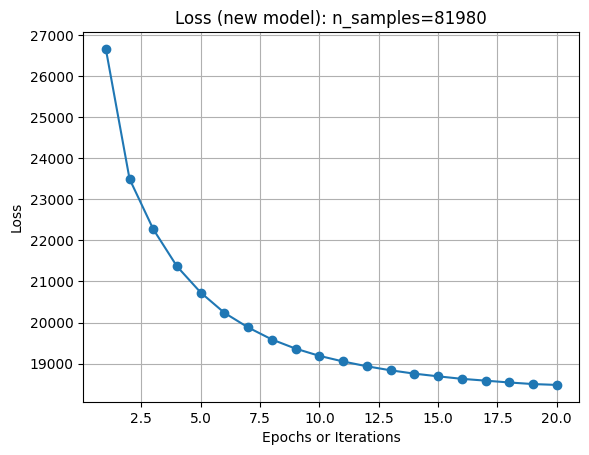

In [ ]:
# 10 gamma w/ 100k samples, 10 window size
model_new_image_enhanced_word2vec, reps_new_image_enhanced_word2vec, word_to_token_new_image_enhanced  = learn_reps_new_image_enhanced_word2vec(
        train_data["caption"], train_data["image_embedding"], WINDOW_SIZE, rep_size=WORD_EMBEDDING_SIZE, image_pca_size=IMAGE_PCA_SIZE,
        loss_gamma=10, n_epochs=N_EPOCHS, n_batch=BATCH_SIZE
)

81980
8130 8130


  5%|▌         | 1/20 [01:32<29:15, 92.38s/it]

epoch : 0, epoch_loss = 247941.0875787735


 10%|█         | 2/20 [03:05<27:47, 92.67s/it]

epoch : 1, epoch_loss = 221110.13840651512


 15%|█▌        | 3/20 [04:37<26:14, 92.61s/it]

epoch : 2, epoch_loss = 209560.65732884407


 20%|██        | 4/20 [06:10<24:41, 92.62s/it]

epoch : 3, epoch_loss = 200628.72926831245


 25%|██▌       | 5/20 [07:42<23:05, 92.39s/it]

epoch : 4, epoch_loss = 193886.4542143345


 30%|███       | 6/20 [09:14<21:33, 92.43s/it]

epoch : 5, epoch_loss = 188825.05400967598


 35%|███▌      | 7/20 [10:47<20:02, 92.53s/it]

epoch : 6, epoch_loss = 184759.74679160118


 40%|████      | 8/20 [12:20<18:33, 92.77s/it]

epoch : 7, epoch_loss = 181638.83467662334


 45%|████▌     | 9/20 [13:53<17:00, 92.79s/it]

epoch : 8, epoch_loss = 178919.23777198792


 50%|█████     | 10/20 [15:26<15:27, 92.72s/it]

epoch : 9, epoch_loss = 176915.72535324097


 55%|█████▌    | 11/20 [16:58<13:54, 92.70s/it]

epoch : 10, epoch_loss = 175116.23809576035


 60%|██████    | 12/20 [18:32<12:22, 92.82s/it]

epoch : 11, epoch_loss = 173733.22649395466


 65%|██████▌   | 13/20 [20:04<10:48, 92.64s/it]

epoch : 12, epoch_loss = 172437.97889053822


 70%|███████   | 14/20 [21:36<09:14, 92.43s/it]

epoch : 13, epoch_loss = 171384.19123733044


 75%|███████▌  | 15/20 [23:08<07:41, 92.38s/it]

epoch : 14, epoch_loss = 170431.89521110058


 80%|████████  | 16/20 [24:40<06:09, 92.28s/it]

epoch : 15, epoch_loss = 169656.17453825474


 85%|████████▌ | 17/20 [26:12<04:36, 92.18s/it]

epoch : 16, epoch_loss = 168830.39898264408


 90%|█████████ | 18/20 [27:43<03:03, 91.89s/it]

epoch : 17, epoch_loss = 168366.07370471954


 95%|█████████▌| 19/20 [29:15<01:31, 91.83s/it]

epoch : 18, epoch_loss = 167816.28219473362


100%|██████████| 20/20 [30:47<00:00, 92.36s/it]

epoch : 19, epoch_loss = 167332.31866657734


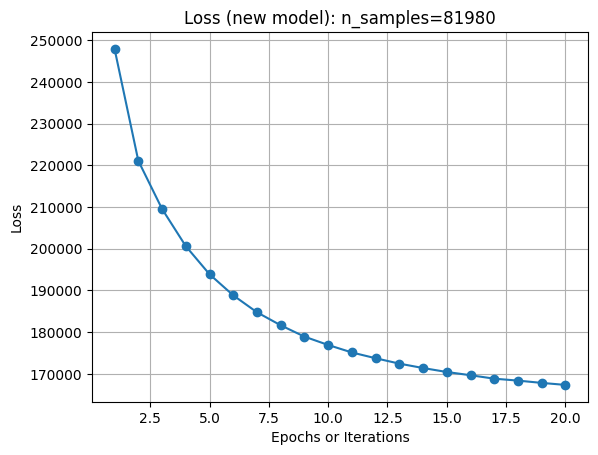

In [ ]:
# 0 gamma w/ 100k samples, 10 window size
model_new_image_enhanced_word2vec, reps_new_image_enhanced_word2vec, word_to_token_new_image_enhanced  = learn_reps_new_image_enhanced_word2vec(
        train_data["caption"], train_data["image_embedding"], WINDOW_SIZE, rep_size=WORD_EMBEDDING_SIZE, image_pca_size=IMAGE_PCA_SIZE,
        loss_gamma=0, n_epochs=N_EPOCHS, n_batch=BATCH_SIZE
)

## Baseline Word2Vec Model

In [ ]:
class BasicWord2VecModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, padding_idx):
        super().__init__()
        self.padded_size = vocab_size + 1 # padding for constant length

        # Embedding layer for context words
        self.input_embedding = nn.Embedding(self.padded_size, embedding_size, padding_idx=padding_idx).to('cuda') # run on colab gpu

        # Embedding layer for target words
        self.output_embedding = nn.Linear(embedding_size, self.padded_size).to('cuda')

    def forward(self, context):
        # out put vector dotted summed input context vectors/context window size

         # Embed context words
        context_embeddings = self.input_embedding(context)  # Shape: n_batch x n_context x embedding_size

        # Sum the embeddings along the context dimension
        summed_context = context_embeddings.sum(dim=1)  # Shape: n_batch x embedding_size

        predicted_scores = self.output_embedding(summed_context)

        return predicted_scores[:,:self.padded_size - 1]

In [ ]:
def learn_reps_basic_word2vec(captions, window_size, rep_size, n_epochs, n_batch):
    # This method takes in a corpus of training sentences. It returns a matrix of
    # word embeddings with the same structure as used in the previous section of
    # the assignment. (You can extract this matrix from the parameters of the
    # Word2VecModel.)

    tokenizer = Tokenizer()
    tokenizer.fit(captions)
    tokenized_captions = tokenizer.tokenize(captions)
    ngrams = []
    pad_idx = tokenizer.vocab_size

    for i, cap in enumerate(tokenized_captions):
      # if i % 500 == 0:
      #   print(f"get ngrams for cap of length {len(cap)}:\n {cap}")
      try:
        ngrams_i = get_ngrams(cap, window_size, pad_idx)
        ngrams.extend(ngrams_i)
      except:
        continue

    device = torch.device('cuda')  # run on colab gpu
    model = BasicWord2VecModel(tokenizer.vocab_size, rep_size, pad_idx).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)

    print(f"Captions in dataset generated {len(ngrams)} {window_size * 2 + 1}-grams")
    loader = torch_data.DataLoader(ngrams, batch_size=n_batch, shuffle=True)

    loss_fn = nn.CrossEntropyLoss()

    losses = []  # Potentially useful for debugging (loss should go down!)
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0

        for context, label in loader:
            context=context.to(device)
            label = label.to(device)
            preds = model(context)

            loss = loss_fn(preds,label)
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item()
        losses.append(epoch_loss)
        print(f"epoch : {epoch}, epoch_loss = {epoch_loss}")

    epochs = range(1, len(losses) + 1)

    # Create a line plot of losses
    plt.plot(epochs, losses, marker='o', linestyle='-')
    plt.title('Loss Over Time')
    plt.xlabel('Epochs or Iterations')
    plt.ylabel('Loss')
    plt.grid(True)

    # Show the plot
    plt.show()
    embedding_matrix = model.input_embedding.weight.cpu().detach().numpy()[:tokenizer.vocab_size,:]

    # Download the embeddings and tokenization for future use
    current_time = datetime.now().strftime("%m-%d-%H:%M")
    full_file_path = os.path.join(DRIVE_BASE_PATH, f"Result Embeddings/Vanilla Word2Vec Model/w2v_embeddings_{len(train_data)}_samples_{current_time}")
    with open(full_file_path, 'wb') as file:
      data = {"embeddings": embedding_matrix, "word_to_token": tokenizer.word_to_token}
      pickle.dump(data, file)

    return model, embedding_matrix, tokenizer.word_to_token

Captions in dataset generated 833212 5-grams


  5%|▌         | 1/20 [01:10<22:14, 70.24s/it]

epoch : 0, epoch_loss = 226051.27501177788


 10%|█         | 2/20 [02:20<21:08, 70.49s/it]

epoch : 1, epoch_loss = 201649.05497193336


 15%|█▌        | 3/20 [03:31<19:55, 70.33s/it]

epoch : 2, epoch_loss = 193460.7813501358


 20%|██        | 4/20 [04:41<18:46, 70.39s/it]

epoch : 3, epoch_loss = 186742.27327871323


 25%|██▌       | 5/20 [05:51<17:35, 70.38s/it]

epoch : 4, epoch_loss = 182213.0760102272


 30%|███       | 6/20 [07:01<16:23, 70.25s/it]

epoch : 5, epoch_loss = 179264.14679694176


 35%|███▌      | 7/20 [08:12<15:13, 70.28s/it]

epoch : 6, epoch_loss = 177003.8373810053


 40%|████      | 8/20 [09:22<14:04, 70.37s/it]

epoch : 7, epoch_loss = 175151.2349410057


 45%|████▌     | 9/20 [10:32<12:53, 70.30s/it]

epoch : 8, epoch_loss = 173774.88540923595


 50%|█████     | 10/20 [11:42<11:42, 70.22s/it]

epoch : 9, epoch_loss = 172538.58115434647


 55%|█████▌    | 11/20 [12:54<10:34, 70.50s/it]

epoch : 10, epoch_loss = 171482.42097198963


 60%|██████    | 12/20 [14:04<09:23, 70.40s/it]

epoch : 11, epoch_loss = 170642.87977039814


 65%|██████▌   | 13/20 [15:15<08:13, 70.56s/it]

epoch : 12, epoch_loss = 169954.28825497627


 70%|███████   | 14/20 [16:26<07:04, 70.73s/it]

epoch : 13, epoch_loss = 169263.66762709618


 75%|███████▌  | 15/20 [17:37<05:53, 70.72s/it]

epoch : 14, epoch_loss = 168649.17418694496


 80%|████████  | 16/20 [18:47<04:42, 70.67s/it]

epoch : 15, epoch_loss = 168134.8302154541


 85%|████████▌ | 17/20 [19:57<03:31, 70.47s/it]

epoch : 16, epoch_loss = 167771.72365176678


 90%|█████████ | 18/20 [21:07<02:20, 70.34s/it]

epoch : 17, epoch_loss = 167281.85380625725


 95%|█████████▌| 19/20 [22:17<01:10, 70.32s/it]

epoch : 18, epoch_loss = 167026.54202997684


100%|██████████| 20/20 [23:28<00:00, 70.42s/it]

epoch : 19, epoch_loss = 166656.18697297573


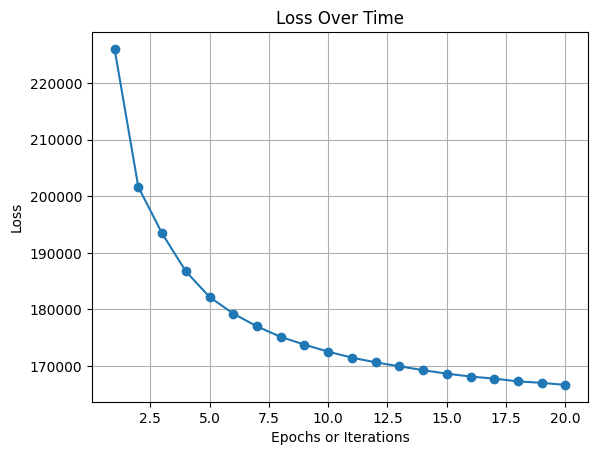

In [ ]:
model_basic_word2vec, basic_reps_word2vec, basic_word2vec_word_to_token = learn_reps_basic_word2vec(
    train_data["caption"], WINDOW_SIZE, WORD_EMBEDDING_SIZE, N_EPOCHS, BATCH_SIZE)

# Load Trained Embeddings

Only need to do this to evaluate the results of a model that has already been trained, and whose resulting embeddings have already been stored in Google Drive. If you just trained a model above, no need to run this cell

In [ ]:
def load_embeddings_and_tokenization(filename, model="Image-Enhanced Model"):
  path = f"{DRIVE_BASE_PATH}/Result Embeddings/{model}/{filename}"
  with open (path, "rb") as file:
    data = pickle.load(file)
    return data["embeddings"], data["word_to_token"]

reps_new_gamma_0, word_to_token_new_gamma_0 = load_embeddings_and_tokenization("new_w2v_enhanced_embeddings_81980_samples_0_gamma_12-04-16:14")
reps_new_gamma_10, word_to_token_new_gamma_10 = load_embeddings_and_tokenization("new_w2v_enhanced_embeddings_81980_samples-0.9-gamma")
reps_new_gamma_50, word_to_token_new_gamma_50 = load_embeddings_and_tokenization("new_w2v_enhanced_embeddings_81980_samples-50-gamma")
reps_new_gamma_250, word_to_token_new_gamma_250 = load_embeddings_and_tokenization("new_w2v_enhanced_embeddings_81980_samples-250-gamma")

# Evaluation: Show Similar Words

In [ ]:
words = ["beach", "yellow", "purple", "bus", "pizza", "dog", "cat", "the"]
show_tokens = [word_to_token[word] for word in words]

captions = train_data["caption"]
tokenizer = Tokenizer()
tokenizer.fit(captions)

word_to_token = tokenizer.word_to_token

In [ ]:
show_similar_words(tokenizer, reps_new_gamma_250, show_tokens)

beach 886
  sandy 0.369
  beaches 0.371
  sea 0.373
  ocean 0.396
  coast 0.456
yellow 265
  pink 1.007
  green 1.086
  white 1.158
  colorful 1.171
  leaf 1.182
purple 2369
  pink 0.874
  black 1.074
  gold 1.100
  dark 1.129
  gray 1.172
bus 4
  buses 0.775
  tram 0.806
  traffic 0.812
  cars 0.846
  taxi 0.847
pizza 2316
  breakfast 0.507
  dinner 0.704
  meal 0.748
  food 0.814
  oven 0.826
dog 129
  puppy 0.448
  dogs 0.502
  kitten 0.569
  cat 0.580
  animal 0.750
cat 442
  kitten 0.284
  puppy 0.447
  cats 0.493
  dog 0.580
  pug 0.621
the 51
  a 0.980
  their 1.202
  his 1.229
  our 1.315
  its 1.321


In [ ]:
show_similar_words(tokenizer, reps_new_gamma_0, show_tokens)

beach 886
  shore 0.688
  coast 0.812
  shores 0.859
  beaches 0.861
  ground 0.919
yellow 265
  pink 1.066
  red 1.105
  purple 1.173
  green 1.235
  blue 1.240
purple 2369
  pink 0.755
  grey 1.039
  black 1.112
  beige 1.139
  blue 1.147
bus 4
  train 1.021
  tram 1.103
  buses 1.162
  guided 1.186
  car 1.204
pizza 2316
  cookie 0.973
  breakfast 1.001
  milk 1.042
  watermelon 1.079
  fork 1.085
dog 129
  puppy 0.722
  dogs 0.860
  kitten 0.892
  cat 0.946
  baby 1.043
cat 442
  kitten 0.695
  puppy 0.769
  pug 0.872
  squirrel 0.884
  dog 0.946
the 51
  a 0.899
  its 1.141
  our 1.142
  their 1.144
  his 1.194


# Evaluation: MEN dataset (words similarity)

In [ ]:
# Takes in a list of captions and a list of all words in vocabulary
# Returns map from word to the mean of all image embeddings of images whose caption contains that word
def averaged_image_embeddings(data, words):
    answer = { w : [] for w in words }

    for i in range(len(data)):
      for w in data[i]["caption"].split():
        if w in answer.keys():
          answer[w].append(data[i]["image_embedding"])


    for w in answer.keys():
      n = len(answer[w])
      if len(answer[w]) > 0:
        d = len(answer[w][0])
        answer[w] = np.array(answer[w]).reshape(n, d)
        answer[w] = answer[w].mean(axis = 0).reshape(-1, 1)
        assert(answer[w].shape == (d, 1))

    return answer

In [ ]:
# this is same as dot(A, B) / (||A|| * ||B||)
from sklearn.metrics.pairwise import cosine_similarity
# The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets
from scipy.stats import spearmanr
from google.colab import drive

men_data_file_path = f"{DRIVE_BASE_PATH}/MEN Data/MEN_dataset_natural_form_full"

def process_men_data():
    file1 = open(men_data_file_path, 'r')
    lines = file1.readlines()

    words_and_scores = []

    # Strips the newline character
    for line in lines:
        arr = line.split()
        assert(len(arr) == 3)
        words_and_scores.append( [arr[0], arr[1], float(arr[2]) * 2] )

    return words_and_scores

def compare_similarities(words_and_scores, word_to_token, learnt_reps,
                         averaged_image_embeddings = None, LAM = None, show_graph = False):
    """
    words_and_scores : list of triples (w1, w2, men_score)
    """

    cosine_similarities, men_scores, word_pairs = [], [], []
    for w1, w2, score in words_and_scores:

      if (w1 not in word_to_token.keys()) or (w2 not in word_to_token.keys()):
        continue

      embed1, embed2 = learnt_reps[word_to_token[w1]], learnt_reps[word_to_token[w2]]

      # assert type(embed1) == list, f"{type(embed1)}"

      if averaged_image_embeddings is not None:
        if (w1 not in averaged_image_embeddings.keys()) or (w2 not in averaged_image_embeddings.keys()):
            continue
        else:
          if LAM is None:
            LAM = 1
          embed1 = np.concatenate([ (1 / (1 + LAM)) * embed1,
                (LAM / (1 + LAM)) * averaged_image_embeddings[w1].reshape(-1)]
                                  )

          embed2 = np.concatenate([ (1 / (1 + LAM)) * embed2,
                (LAM / (1 + LAM)) * averaged_image_embeddings[w2].reshape(-1)]
                                  )
      word_pairs.append((w1, w2))
      cosine_similarities.append(cosine_similarity(embed1.reshape(1, -1), embed2.reshape(1, -1))[0][0] )
      men_scores.append(score)

    if show_graph:
      print(f'Total number of pairs = {len(cosine_similarities)}')
      adjusted_men_scores = np.array(men_scores) / 100
      plot_indices = np.random.choice(len(cosine_similarities), 50)
      plotted_pairs = [(word_pairs[i], adjusted_men_scores[i], cosine_similarities[i]) for i in plot_indices]
      print("plotting", plotted_pairs)

      plt.scatter(adjusted_men_scores[plot_indices], np.array(cosine_similarities)[plot_indices])
      plt.title("Selected cosine similarities vs. MEN scores")
      plt.ylabel("Cosine similarity between a pair of word embeddings")
      plt.xlabel("MEN score for a pair of words")

    # return np.corrcoef(cosine_similarities, men_scores)
    spearman_coef = spearmanr(cosine_similarities, men_scores)
    return spearman_coef.statistic

### Old Image-Enhanced Model

In [ ]:
train_averaged_image_embeddings = averaged_image_embeddings(train_data,
                                                            list(word_to_token_enhanced[1].keys()))

for LAM in LAMBDAS_TO_TRY:
    sim_score = compare_similarities(words_and_scores = process_men_data(),
                                 word_to_token = word_to_token_enhanced[LAM],
                                 learnt_reps = reps_enhanced[LAM],
                                  averaged_image_embeddings = train_averaged_image_embeddings)

    print(f"Spearman coefficient for lambda={LAM}: {sim_score}")

Total number of pairs = 2697
Spearman coefficient for lambda=1: 0.2868361835946353


### New Image-Enhanced Model

In [ ]:
train_averaged_image_embeddings = averaged_image_embeddings(train_data, list(word_to_token_new_image_enhanced.keys()))

In [ ]:
sim_score = compare_similarities(words_and_scores = process_men_data(),
                                 word_to_token = word_to_token_new_image_enhanced,
                                 learnt_reps = reps_new_image_enhanced_word2vec,
                                  averaged_image_embeddings = None)

print(f"Spearman coefficient for new model: {sim_score}")

Spearman coefficient for new model: 0.2542604284953706


### Baseline Word2Vec Model

In [ ]:
sim_score = compare_similarities(words_and_scores = process_men_data(),
                              word_to_token = basic_word2vec_word_to_token,
                              learnt_reps = basic_reps_word2vec,
                              averaged_image_embeddings = None)

print(f"Spearman coefficient for baseline word2vec: {sim_score}")

Total number of pairs = 2697
Spearman coefficient for baseline word2vec: 0.4438420070421831


## Loaded from G-drive models

In [ ]:
train_averaged_image_embeddings = averaged_image_embeddings(train_data, list(word_to_token_new_gamma_50.keys()))

Total number of pairs = 2697
plotting [(('stand', 'walk'), 0.56, 0.42197064), (('cathedral', 'interior'), 0.44, 0.24954696), (('breakfast', 'dinner'), 0.74, 0.5842054), (('evening', 'sleep'), 0.66, 0.12232857), (('bedroom', 'kitchen'), 0.6, 0.4174435), (('cactus', 'porch'), 0.24, 0.086771466), (('left', 'stop'), 0.38, 0.054182258), (('feel', 'hanging'), 0.2, 0.060478333), (('fruit', 'tomato'), 0.78, 0.21447307), (('santa', 'table'), 0.18, 0.14055361), (('art', 'collage'), 0.66, 0.15260403), (('key', 'stone'), 0.42, 0.24302423), (('born', 'living'), 0.7, 0.06232957), (('tea', 'village'), 0.22, 0.09485688), (('eyes', 'sky'), 0.32, 0.38136426), (('coffee', 'room'), 0.4, -0.017264986), (('feel', 'spiral'), 0.18, 0.022634283), (('bedroom', 'ceiling'), 0.76, 0.33487204), (('lips', 'tongue'), 0.82, 0.35068077), (('mirror', 'raspberry'), 0.08, 0.11290959), (('interior', 'roof'), 0.62, 0.35169858), (('coast', 'downtown'), 0.36, 0.296509), (('soup', 'sweet'), 0.38, 0.1560525), (('bloom', 'buds')

0.42634397367335536

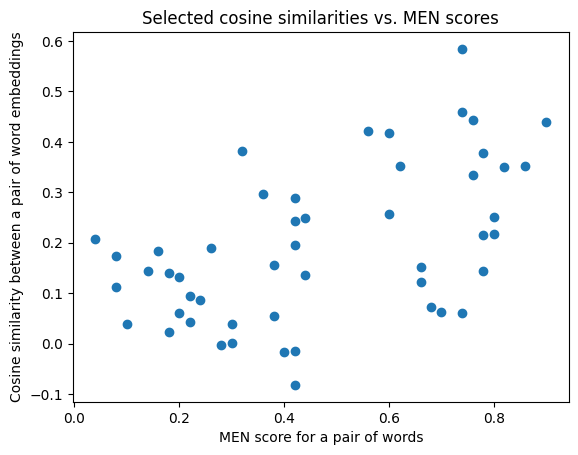

In [ ]:
compare_similarities(
    words_and_scores = process_men_data(),
    word_to_token = word_to_token_new_gamma_0,
    learnt_reps = reps_new_gamma_0,
    averaged_image_embeddings = None
)

Total number of pairs = 2697


0.16571006679705177

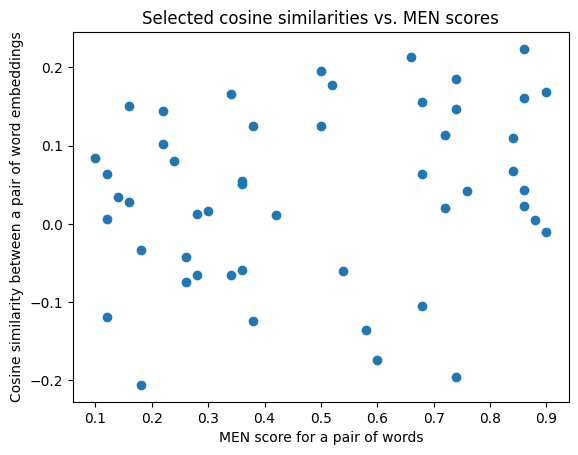

In [ ]:
compare_similarities(
    words_and_scores = process_men_data(),
    word_to_token = word_to_token_new_gamma_10,
    learnt_reps = reps_new_gamma_10,
    averaged_image_embeddings = None
)

Total number of pairs = 2697


0.515860924322386

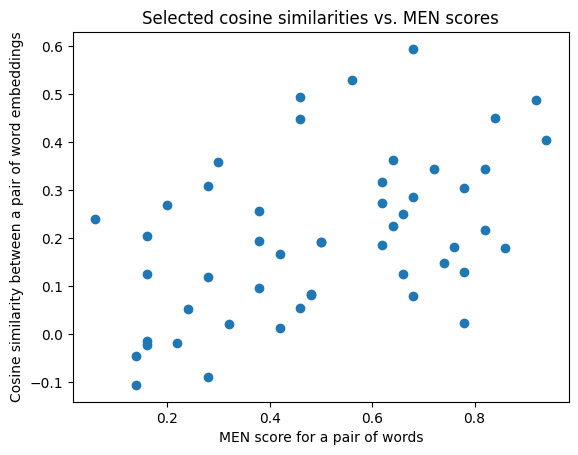

In [ ]:
compare_similarities(
    words_and_scores = process_men_data(),
    word_to_token = word_to_token_new_gamma_50,
    learnt_reps = reps_new_gamma_50,
    averaged_image_embeddings = None
)

Total number of pairs = 2697
plotting [(('match', 'round'), 0.54, 0.24274836), (('floor', 'marble'), 0.72, 0.29865927), (('fishing', 'shore'), 0.6, 0.5050415), (('foliage', 'restaurant'), 0.22, 0.022289237), (('palm', 'tree'), 0.74, -0.061171826), (('train', 'underground'), 0.54, 0.31638628), (('airplane', 'airport'), 0.82, 0.32508498), (('cheetah', 'lion'), 0.8, 0.5166459), (('stream', 'waterfall'), 0.78, 0.80515975), (('hummingbird', 'tropical'), 0.52, -0.16809799), (('game', 'husky'), 0.12, 0.03495202), (('eat', 'soup'), 0.78, 0.33052152), (('downtown', 'locked'), 0.28, -0.065390155), (('colour', 'red'), 0.82, -0.059588064), (('barn', 'owl'), 0.48, 0.072280936), (('collage', 'exhibition'), 0.62, 0.268056), (('skirt', 'wig'), 0.22, 0.12867576), (('cat', 'purple'), 0.14, 0.10723258), (('bed', 'bedroom'), 0.84, 0.82687336), (('landscape', 'scenery'), 0.76, 0.550664), (('bucket', 'duck'), 0.16, 0.105883926), (('purple', 'white'), 0.72, 0.31534785), (('bar', 'cafe'), 0.64, 0.56868285), (

0.5734780765047204

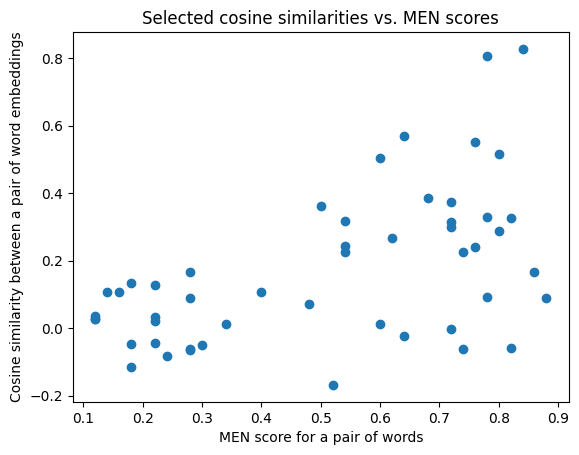

In [ ]:
compare_similarities(
    words_and_scores = process_men_data(),
    word_to_token = word_to_token_new_gamma_250,
    learnt_reps = reps_new_gamma_250,
    averaged_image_embeddings = None
)

# Scratch stuff

In [ ]:
# # trained vanilla model on 100k samples to see how big MEN score can be
# # reps_word2vec = learn_reps_basic_word2vec(dataset_filtered["caption"], 2, 500, 5, 100)
# window_size = 2
# n_batch = 500
# embedding_size = 200
# n_epochs = 15


# model_basic_word2vec, reps_word2vec, basic_word2vec_word_to_token = learn_reps_basic_word2vec(
#     dataset_train["caption"], window_size, embedding_size, n_epochs, n_batch)


# sim_score = compare_similarities(words_and_scores = process_med_data(),
#                                  word_to_token = basic_word2vec_word_to_token,
#                                  learnt_reps = reps_word2vec)
# print(sim_score)

In [ ]:
# #### NEW, scratch work from VLAD, doesn't matter for the report.

# LAMBDAS_TO_TRY = [0, 0.03, 0.1, 1, 2, 5]

bulding model for LAM = 0
7889 7889


  5%|▌         | 1/20 [00:18<05:49, 18.38s/it]

epoch : 0, epoch_loss = 27981.07549929619


 10%|█         | 2/20 [00:36<05:25, 18.10s/it]

epoch : 1, epoch_loss = 21782.64013171196


 15%|█▌        | 3/20 [00:54<05:09, 18.21s/it]

epoch : 2, epoch_loss = 18996.2836933136


 20%|██        | 4/20 [01:12<04:51, 18.25s/it]

epoch : 3, epoch_loss = 17048.213782072067


 25%|██▌       | 5/20 [01:30<04:32, 18.15s/it]

epoch : 4, epoch_loss = 15571.476358532906


 30%|███       | 6/20 [01:48<04:13, 18.11s/it]

epoch : 5, epoch_loss = 14404.905203461647


 35%|███▌      | 7/20 [02:07<03:55, 18.10s/it]

epoch : 6, epoch_loss = 13451.159489512444


 40%|████      | 8/20 [02:24<03:36, 18.05s/it]

epoch : 7, epoch_loss = 12631.850024104118


 45%|████▌     | 9/20 [02:42<03:18, 18.00s/it]

epoch : 8, epoch_loss = 11914.580458283424


 50%|█████     | 10/20 [03:00<02:59, 18.00s/it]

epoch : 9, epoch_loss = 11283.867188215256


 55%|█████▌    | 11/20 [03:18<02:42, 18.03s/it]

epoch : 10, epoch_loss = 10720.964811086655


 60%|██████    | 12/20 [03:36<02:24, 18.03s/it]

epoch : 11, epoch_loss = 10205.644464492798


 65%|██████▌   | 13/20 [03:55<02:06, 18.07s/it]

epoch : 12, epoch_loss = 9737.945435285568


 70%|███████   | 14/20 [04:13<01:48, 18.08s/it]

epoch : 13, epoch_loss = 9311.092960953712


 75%|███████▌  | 15/20 [04:31<01:30, 18.03s/it]

epoch : 14, epoch_loss = 8919.931016027927


 80%|████████  | 16/20 [04:49<01:11, 17.98s/it]

epoch : 15, epoch_loss = 8578.656542778015


 85%|████████▌ | 17/20 [05:06<00:53, 17.96s/it]

epoch : 16, epoch_loss = 8267.382730901241


 90%|█████████ | 18/20 [05:24<00:35, 17.91s/it]

epoch : 17, epoch_loss = 7965.076540470123


 95%|█████████▌| 19/20 [05:42<00:17, 17.90s/it]

epoch : 18, epoch_loss = 7714.656661748886


100%|██████████| 20/20 [06:00<00:00, 18.04s/it]

epoch : 19, epoch_loss = 7482.201655834913


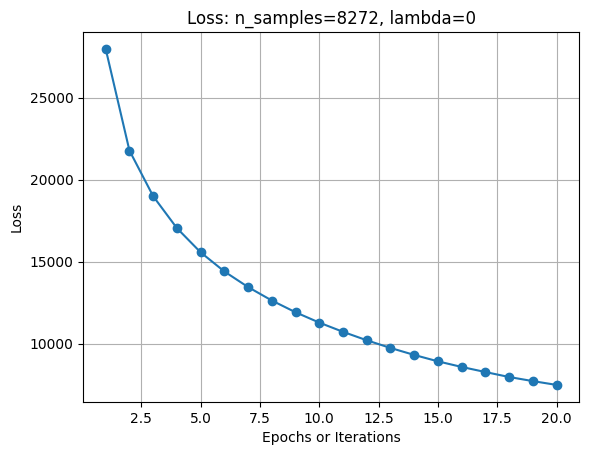

bulding model for LAM = 0.03
7889 7889


  5%|▌         | 1/20 [00:17<05:41, 17.96s/it]

epoch : 0, epoch_loss = 27792.281870126724


 10%|█         | 2/20 [00:35<05:22, 17.93s/it]

epoch : 1, epoch_loss = 21475.741557121277


 15%|█▌        | 3/20 [00:53<05:05, 17.95s/it]

epoch : 2, epoch_loss = 18506.176560401917


 20%|██        | 4/20 [01:11<04:48, 18.00s/it]

epoch : 3, epoch_loss = 16385.249825954437


 25%|██▌       | 5/20 [01:30<04:30, 18.03s/it]

epoch : 4, epoch_loss = 14753.530599713326


 30%|███       | 6/20 [01:47<04:11, 17.99s/it]

epoch : 5, epoch_loss = 13468.226026177406


 35%|███▌      | 7/20 [02:05<03:53, 17.95s/it]

epoch : 6, epoch_loss = 12399.762457847595


 40%|████      | 8/20 [02:23<03:35, 17.93s/it]

epoch : 7, epoch_loss = 11507.055449962616


 45%|████▌     | 9/20 [02:41<03:17, 17.93s/it]

epoch : 8, epoch_loss = 10715.543060302734


 50%|█████     | 10/20 [02:59<02:59, 17.96s/it]

epoch : 9, epoch_loss = 10017.882574856281


 55%|█████▌    | 11/20 [03:17<02:42, 18.02s/it]

epoch : 10, epoch_loss = 9380.656111836433


 60%|██████    | 12/20 [03:36<02:24, 18.11s/it]

epoch : 11, epoch_loss = 8811.79896068573


 65%|██████▌   | 13/20 [03:54<02:06, 18.07s/it]

epoch : 12, epoch_loss = 8302.291417121887


 70%|███████   | 14/20 [04:12<01:48, 18.02s/it]

epoch : 13, epoch_loss = 7828.787387549877


 75%|███████▌  | 15/20 [04:29<01:29, 17.99s/it]

epoch : 14, epoch_loss = 7403.681728065014


 80%|████████  | 16/20 [04:47<01:11, 17.97s/it]

epoch : 15, epoch_loss = 7029.897521913052


 85%|████████▌ | 17/20 [05:05<00:53, 18.00s/it]

epoch : 16, epoch_loss = 6680.74287456274


 90%|█████████ | 18/20 [05:24<00:36, 18.07s/it]

epoch : 17, epoch_loss = 6367.203501790762


 95%|█████████▌| 19/20 [05:42<00:18, 18.08s/it]

epoch : 18, epoch_loss = 6070.244794845581


100%|██████████| 20/20 [06:00<00:00, 18.01s/it]

epoch : 19, epoch_loss = 5820.086656033993


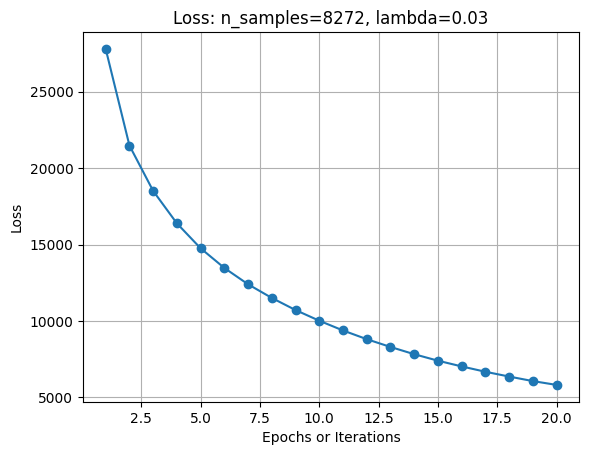

bulding model for LAM = 0.1
7889 7889


  5%|▌         | 1/20 [00:18<05:42, 18.01s/it]

epoch : 0, epoch_loss = 27463.568996667862


 10%|█         | 2/20 [00:36<05:25, 18.09s/it]

epoch : 1, epoch_loss = 20758.62983727455


 15%|█▌        | 3/20 [00:54<05:07, 18.12s/it]

epoch : 2, epoch_loss = 17495.167145252228


 20%|██        | 4/20 [01:12<04:48, 18.05s/it]

epoch : 3, epoch_loss = 15135.841805696487


 25%|██▌       | 5/20 [01:30<04:30, 18.01s/it]

epoch : 4, epoch_loss = 13318.975425124168


 30%|███       | 6/20 [01:48<04:11, 17.98s/it]

epoch : 5, epoch_loss = 11912.578182935715


 35%|███▌      | 7/20 [02:05<03:53, 17.94s/it]

epoch : 6, epoch_loss = 10778.083662986755


 40%|████      | 8/20 [02:23<03:35, 17.94s/it]

epoch : 7, epoch_loss = 9813.2366284132


 45%|████▌     | 9/20 [02:41<03:17, 17.97s/it]

epoch : 8, epoch_loss = 8980.939078092575


 50%|█████     | 10/20 [03:00<02:59, 18.00s/it]

epoch : 9, epoch_loss = 8245.80218604207


 55%|█████▌    | 11/20 [03:17<02:41, 17.97s/it]

epoch : 10, epoch_loss = 7605.957480788231


 60%|██████    | 12/20 [03:35<02:23, 17.93s/it]

epoch : 11, epoch_loss = 7024.140243649483


 65%|██████▌   | 13/20 [03:53<02:05, 17.91s/it]

epoch : 12, epoch_loss = 6503.309846967459


 70%|███████   | 14/20 [04:11<01:47, 17.92s/it]

epoch : 13, epoch_loss = 6039.6209063231945


 75%|███████▌  | 15/20 [04:29<01:29, 17.92s/it]

epoch : 14, epoch_loss = 5627.203015387058


 80%|████████  | 16/20 [04:47<01:11, 17.98s/it]

epoch : 15, epoch_loss = 5254.618244886398


 85%|████████▌ | 17/20 [05:05<00:54, 18.00s/it]

epoch : 16, epoch_loss = 4913.140769690275


 90%|█████████ | 18/20 [05:23<00:35, 17.98s/it]

epoch : 17, epoch_loss = 4615.818914890289


 95%|█████████▌| 19/20 [05:41<00:17, 17.95s/it]

epoch : 18, epoch_loss = 4332.133059412241


100%|██████████| 20/20 [05:59<00:00, 17.97s/it]

epoch : 19, epoch_loss = 4086.1347095668316


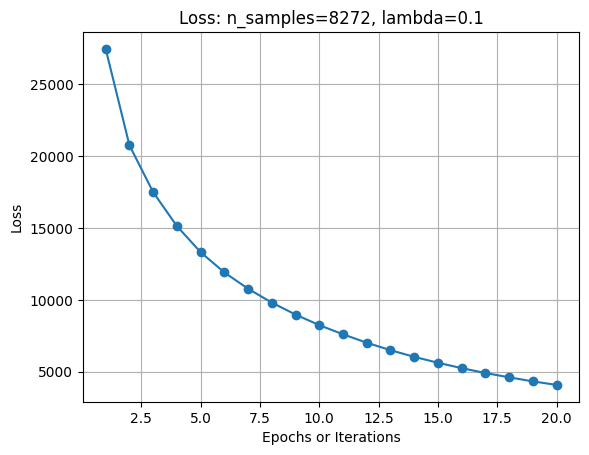

bulding model for LAM = 1
7889 7889


  5%|▌         | 1/20 [00:18<05:44, 18.12s/it]

epoch : 0, epoch_loss = 26435.988445281982


 10%|█         | 2/20 [00:36<05:25, 18.08s/it]

epoch : 1, epoch_loss = 18943.358479499817


 15%|█▌        | 3/20 [00:54<05:05, 17.99s/it]

epoch : 2, epoch_loss = 14904.55367732048


 20%|██        | 4/20 [01:12<04:47, 18.00s/it]

epoch : 3, epoch_loss = 12069.66992533207


 25%|██▌       | 5/20 [01:30<04:30, 18.01s/it]

epoch : 4, epoch_loss = 10100.342945456505


 30%|███       | 6/20 [01:48<04:11, 17.99s/it]

epoch : 5, epoch_loss = 8663.133724331856


 35%|███▌      | 7/20 [02:06<03:54, 18.03s/it]

epoch : 6, epoch_loss = 7547.462950706482


 40%|████      | 8/20 [02:24<03:36, 18.07s/it]

epoch : 7, epoch_loss = 6641.69125893712


 45%|████▌     | 9/20 [02:42<03:18, 18.07s/it]

epoch : 8, epoch_loss = 5890.649517416954


 50%|█████     | 10/20 [03:00<03:00, 18.02s/it]

epoch : 9, epoch_loss = 5251.039268612862


 55%|█████▌    | 11/20 [03:18<02:41, 17.99s/it]

epoch : 10, epoch_loss = 4699.904470235109


 60%|██████    | 12/20 [03:36<02:23, 18.00s/it]

epoch : 11, epoch_loss = 4234.507381498814


 65%|██████▌   | 13/20 [03:54<02:05, 18.00s/it]

epoch : 12, epoch_loss = 3826.024721428752


 70%|███████   | 14/20 [04:12<01:48, 18.06s/it]

epoch : 13, epoch_loss = 3471.2649469077587


 75%|███████▌  | 15/20 [04:30<01:30, 18.09s/it]

epoch : 14, epoch_loss = 3162.934696048498


 80%|████████  | 16/20 [04:48<01:12, 18.08s/it]

epoch : 15, epoch_loss = 2888.3818973749876


 85%|████████▌ | 17/20 [05:06<00:54, 18.06s/it]

epoch : 16, epoch_loss = 2650.9831260740757


 90%|█████████ | 18/20 [05:24<00:36, 18.04s/it]

epoch : 17, epoch_loss = 2445.053266212344


 95%|█████████▌| 19/20 [05:42<00:18, 18.04s/it]

epoch : 18, epoch_loss = 2263.051019228995


100%|██████████| 20/20 [06:00<00:00, 18.03s/it]

epoch : 19, epoch_loss = 2094.606599599123


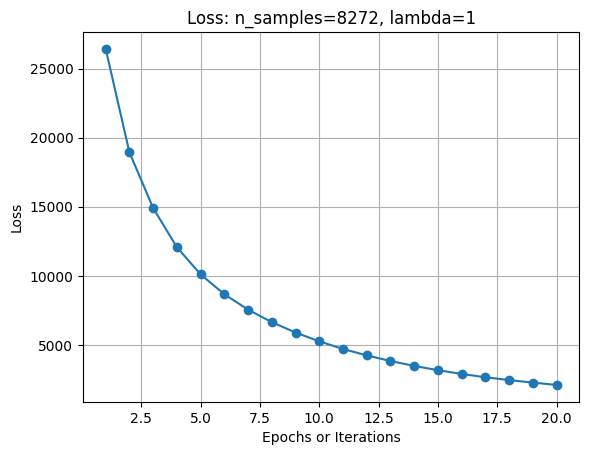

In [ ]:
# models_enhanced, reps_enhanced, word_to_token_enhanced = {}, {}, {}

# LAMBDAS_TO_TRY = [0, 0.03, 0.1, 1]

# for LAM in LAMBDAS_TO_TRY:
#     print(f'bulding model for LAM = {LAM}')
#     model_image_enhanced_word2vec, reps_image_enhanced_word2vec, word_to_token_image_enhanced  = learn_reps_image_enhanced_word2vec(
#         train_data["caption"], train_data["image_embedding"], WINDOW_SIZE, rep_size = WORD_EMBEDDING_SIZE,
#         n_epochs = 20, n_batch = BATCH_SIZE, LAMBDA = LAM
#     )
#     models_enhanced[LAM] = model_image_enhanced_word2vec
#     reps_enhanced[LAM] = reps_image_enhanced_word2vec
#     word_to_token_enhanced[LAM] = word_to_token_image_enhanced

bulding model for LAM = 2
7889 7889


  5%|▌         | 1/20 [00:19<06:11, 19.56s/it]

epoch : 0, epoch_loss = 26355.341864585876


 10%|█         | 2/20 [00:40<06:07, 20.40s/it]

epoch : 1, epoch_loss = 18802.040269851685


 15%|█▌        | 3/20 [00:58<05:29, 19.37s/it]

epoch : 2, epoch_loss = 14701.81845164299


 20%|██        | 4/20 [01:16<05:00, 18.81s/it]

epoch : 3, epoch_loss = 11938.208673000336


 25%|██▌       | 5/20 [01:34<04:39, 18.63s/it]

epoch : 4, epoch_loss = 10045.74708199501


 30%|███       | 6/20 [01:52<04:17, 18.40s/it]

epoch : 5, epoch_loss = 8657.295169889927


 35%|███▌      | 7/20 [02:10<03:57, 18.26s/it]

epoch : 6, epoch_loss = 7567.448434412479


 40%|████      | 8/20 [02:29<03:38, 18.24s/it]

epoch : 7, epoch_loss = 6671.552060127258


 45%|████▌     | 9/20 [02:47<03:20, 18.21s/it]

epoch : 8, epoch_loss = 5930.191428899765


 50%|█████     | 10/20 [03:05<03:01, 18.12s/it]

epoch : 9, epoch_loss = 5293.741017878056


 55%|█████▌    | 11/20 [03:23<02:43, 18.20s/it]

epoch : 10, epoch_loss = 4753.0294687747955


 60%|██████    | 12/20 [03:41<02:24, 18.11s/it]

epoch : 11, epoch_loss = 4289.9232514202595


 65%|██████▌   | 13/20 [03:59<02:06, 18.06s/it]

epoch : 12, epoch_loss = 3879.8822766542435


 70%|███████   | 14/20 [04:17<01:48, 18.08s/it]

epoch : 13, epoch_loss = 3524.221575587988


 75%|███████▌  | 15/20 [04:35<01:30, 18.11s/it]

epoch : 14, epoch_loss = 3212.701356858015


 80%|████████  | 16/20 [04:54<01:12, 18.21s/it]

epoch : 15, epoch_loss = 2938.569747135043


 85%|████████▌ | 17/20 [05:12<00:54, 18.14s/it]

epoch : 16, epoch_loss = 2697.977871105075


 90%|█████████ | 18/20 [05:30<00:36, 18.08s/it]

epoch : 17, epoch_loss = 2483.021990314126


 95%|█████████▌| 19/20 [05:48<00:18, 18.04s/it]

epoch : 18, epoch_loss = 2295.996480844915


100%|██████████| 20/20 [06:06<00:00, 18.30s/it]

epoch : 19, epoch_loss = 2128.856720417738


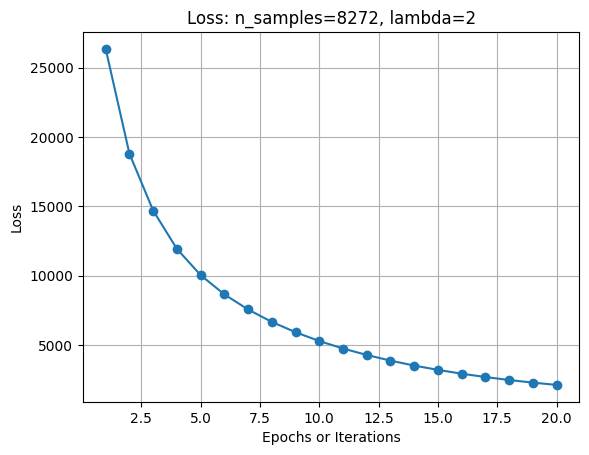

bulding model for LAM = 5
7889 7889


  5%|▌         | 1/20 [00:17<05:40, 17.92s/it]

epoch : 0, epoch_loss = 26505.480271577835


 10%|█         | 2/20 [00:35<05:22, 17.92s/it]

epoch : 1, epoch_loss = 19136.636944532394


 15%|█▌        | 3/20 [00:53<05:04, 17.90s/it]

epoch : 2, epoch_loss = 15121.6407392025


 20%|██        | 4/20 [01:11<04:47, 17.99s/it]

epoch : 3, epoch_loss = 12529.645778298378


 25%|██▌       | 5/20 [01:30<04:30, 18.06s/it]

epoch : 4, epoch_loss = 10796.557315826416


 30%|███       | 6/20 [01:48<04:12, 18.06s/it]

epoch : 5, epoch_loss = 9487.186234235764


 35%|███▌      | 7/20 [02:06<03:54, 18.02s/it]

epoch : 6, epoch_loss = 8435.240039050579


 40%|████      | 8/20 [02:23<03:35, 17.98s/it]

epoch : 7, epoch_loss = 7533.701445877552


 45%|████▌     | 9/20 [02:41<03:17, 17.96s/it]

epoch : 8, epoch_loss = 6785.996468245983


 50%|█████     | 10/20 [02:59<02:59, 17.97s/it]

epoch : 9, epoch_loss = 6127.137104213238


 55%|█████▌    | 11/20 [03:17<02:42, 18.03s/it]

epoch : 10, epoch_loss = 5560.03414940834


 60%|██████    | 12/20 [03:36<02:24, 18.06s/it]

epoch : 11, epoch_loss = 5051.863714814186


 65%|██████▌   | 13/20 [03:54<02:06, 18.06s/it]

epoch : 12, epoch_loss = 4618.008727103472


 70%|███████   | 14/20 [04:12<01:48, 18.10s/it]

epoch : 13, epoch_loss = 4222.891133874655


 75%|███████▌  | 15/20 [04:30<01:30, 18.13s/it]

epoch : 14, epoch_loss = 3873.140489190817


 80%|████████  | 16/20 [04:48<01:12, 18.17s/it]

epoch : 15, epoch_loss = 3566.777669608593


 85%|████████▌ | 17/20 [05:07<00:54, 18.31s/it]

epoch : 16, epoch_loss = 3289.436374604702


 90%|█████████ | 18/20 [05:25<00:36, 18.35s/it]

epoch : 17, epoch_loss = 3042.4466812089086


 95%|█████████▌| 19/20 [05:44<00:18, 18.32s/it]

epoch : 18, epoch_loss = 2823.381830945611


100%|██████████| 20/20 [06:02<00:00, 18.11s/it]

epoch : 19, epoch_loss = 2620.3776367902756


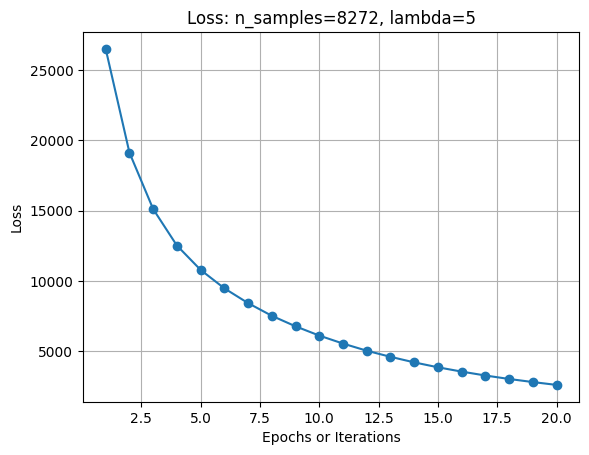

In [ ]:
# for LAM in [2, 5]:
#     print(f'bulding model for LAM = {LAM}')
#     model_image_enhanced_word2vec, reps_image_enhanced_word2vec, word_to_token_image_enhanced  = learn_reps_image_enhanced_word2vec(
#         train_data["caption"], train_data["image_embedding"], WINDOW_SIZE, rep_size = WORD_EMBEDDING_SIZE,
#         n_epochs = 20, n_batch = BATCH_SIZE, LAMBDA = LAM
#     )
#     models_enhanced[LAM] = model_image_enhanced_word2vec
#     reps_enhanced[LAM] = reps_image_enhanced_word2vec
#     word_to_token_enhanced[LAM] = word_to_token_image_enhanced

In [ ]:
train_averaged_image_embeddings = averaged_image_embeddings(train_data,
                                                            list(word_to_token_enhanced[0].keys()) )

Captions in dataset generated 84165 5-grams


  5%|▌         | 1/20 [00:08<02:34,  8.14s/it]

epoch : 0, epoch_loss = 28468.083913087845


 10%|█         | 2/20 [00:18<02:53,  9.61s/it]

epoch : 1, epoch_loss = 21869.97053050995


 15%|█▌        | 3/20 [00:26<02:31,  8.93s/it]

epoch : 2, epoch_loss = 19003.05240225792


 20%|██        | 4/20 [00:35<02:22,  8.92s/it]

epoch : 3, epoch_loss = 17021.10440635681


 25%|██▌       | 5/20 [00:44<02:10,  8.71s/it]

epoch : 4, epoch_loss = 15515.04370880127


 30%|███       | 6/20 [00:53<02:02,  8.77s/it]

epoch : 5, epoch_loss = 14329.788919568062


 35%|███▌      | 7/20 [01:02<01:58,  9.12s/it]

epoch : 6, epoch_loss = 13365.870797395706


 40%|████      | 8/20 [01:11<01:46,  8.84s/it]

epoch : 7, epoch_loss = 12540.251320242882


 45%|████▌     | 9/20 [01:20<01:37,  8.87s/it]

epoch : 8, epoch_loss = 11842.242453694344


 50%|█████     | 10/20 [01:28<01:26,  8.63s/it]

epoch : 9, epoch_loss = 11189.568484604359


 55%|█████▌    | 11/20 [01:37<01:18,  8.75s/it]

epoch : 10, epoch_loss = 10634.95956671238


 60%|██████    | 12/20 [01:45<01:09,  8.64s/it]

epoch : 11, epoch_loss = 10115.012705683708


 65%|██████▌   | 13/20 [01:54<01:00,  8.69s/it]

epoch : 12, epoch_loss = 9651.240354299545


 70%|███████   | 14/20 [02:02<00:51,  8.66s/it]

epoch : 13, epoch_loss = 9225.35720038414


 75%|███████▌  | 15/20 [02:11<00:43,  8.63s/it]

epoch : 14, epoch_loss = 8848.935852348804


 80%|████████  | 16/20 [02:20<00:34,  8.67s/it]

epoch : 15, epoch_loss = 8507.873511254787


 85%|████████▌ | 17/20 [02:28<00:25,  8.55s/it]

epoch : 16, epoch_loss = 8194.252975165844


 90%|█████████ | 18/20 [02:37<00:17,  8.66s/it]

epoch : 17, epoch_loss = 7920.735858619213


 95%|█████████▌| 19/20 [02:45<00:08,  8.50s/it]

epoch : 18, epoch_loss = 7661.283200055361


100%|██████████| 20/20 [02:54<00:00,  8.73s/it]

epoch : 19, epoch_loss = 7434.090261101723


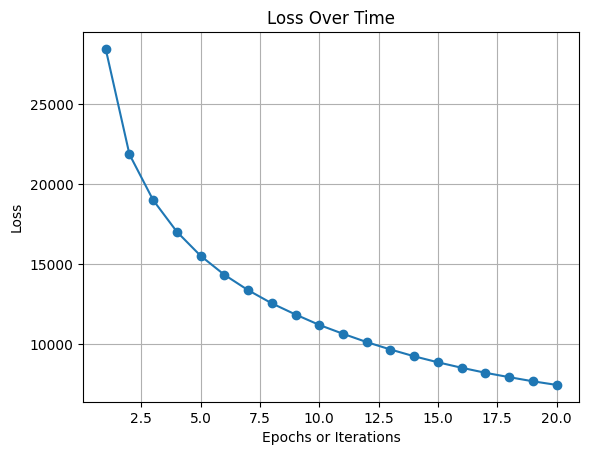

In [ ]:
# # reps_word2vec = learn_reps_basic_word2vec(dataset_filtered["caption"], 2, 500, 5, 100)
# window_size = 2
# n_batch = 20
# embedding_size = 100
# n_epochs = 20

# model_basic_word2vec, basic_reps_word2vec, basic_word2vec_word_to_token = learn_reps_basic_word2vec(
#     train_data["caption"], window_size, embedding_size, n_epochs, n_batch)

In [ ]:
# # old versions, without lambad multiplication
# for LAM in LAMBDAS_TO_TRY:
#     sim_score = compare_similarities(words_and_scores = process_med_data(),
#                                  word_to_token = word_to_token_enhanced[LAM],
#                                  learnt_reps = reps_enhanced[LAM],
#                                   averaged_image_embeddings = train_averaged_image_embeddings)

#     print(f"Spearman coefficient for lambda={LAM}: {sim_score}")

Total number of pairs = 2362
Spearman coefficient for lambda=0: 0.15516004267178174
Total number of pairs = 2362
Spearman coefficient for lambda=0.03: 0.1341560374214756
Total number of pairs = 2362
Spearman coefficient for lambda=0.1: 0.13090969791149257
Total number of pairs = 2362
Spearman coefficient for lambda=1: 0.11596816077543752
Total number of pairs = 2362
Spearman coefficient for lambda=2: 0.11047231268046015
Total number of pairs = 2362
Spearman coefficient for lambda=5: 0.12498883242512865


In [ ]:
# # this is same as dot(A, B) / (||A|| * ||B||)
# from sklearn.metrics.pairwise import cosine_similarity
# # The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets
# from scipy.stats import spearmanr
# from google.colab import drive

# men_data_file_path = f"{DRIVE_BASE_PATH}/MEN Data/MEN_dataset_natural_form_full"

# def process_med_data():
#     file1 = open(men_data_file_path, 'r')
#     lines = file1.readlines()

#     words_and_scores = []

#     # Strips the newline character
#     for line in lines:
#         arr = line.split()
#         assert(len(arr) == 3)
#         words_and_scores.append( [arr[0], arr[1], float(arr[2]) * 2] )

#     return words_and_scores

# def compare_similarities_upd(words_and_scores, word_to_token, learnt_reps,
#                          averaged_image_embeddings = None, LAM = None):
#     """
#     words_and_scores : list of triples (w1, w2, men_score)
#     """

#     cosine_similarities, men_scores = [], []
#     for w1, w2, score in words_and_scores:

#       if (w1 not in word_to_token.keys()) or (w2 not in word_to_token.keys()):
#         continue

#       embed1, embed2 = learnt_reps[word_to_token[w1]], learnt_reps[word_to_token[w2]]

#       # assert type(embed1) == list, f"{type(embed1)}"

#       if averaged_image_embeddings is not None:
#         if (w1 not in averaged_image_embeddings.keys()) or (w2 not in averaged_image_embeddings.keys()):
#             continue
#         else:
#           assert LAM is not None
#           embed1 = np.concatenate([ (1 / (1 + LAM)) * embed1,
#                 (LAM / (1 + LAM)) * averaged_image_embeddings[w1].reshape(-1)]
#                                   )

#           embed2 = np.concatenate([ (1 / (1 + LAM)) * embed2,
#                 (LAM / (1 + LAM)) * averaged_image_embeddings[w2].reshape(-1)]
#                                   )

#       cosine_similarities.append( cosine_similarity(embed1.reshape(1, -1), embed2.reshape(1, -1))[0][0] )
#       men_scores.append(score)

#     print(f'Total number of pairs = {len(cosine_similarities)}')

#     # return np.corrcoef(cosine_similarities, men_scores)
#     spearman_coef = spearmanr(cosine_similarities, men_scores)
#     return spearman_coef.statistic

In [ ]:
# new versions, proper.
for LAM in LAMBDAS_TO_TRY:
    sim_score = compare_similarities_upd(words_and_scores = process_med_data(),
                                 word_to_token = word_to_token_enhanced[LAM],
                                 learnt_reps = reps_enhanced[LAM],
                                  averaged_image_embeddings = train_averaged_image_embeddings,
                                     LAM = LAM)

    print(f"Spearman coefficient for lambda={LAM}: {sim_score}")

Total number of pairs = 2362
Spearman coefficient for lambda=0: 0.12196654002108154
Total number of pairs = 2362
Spearman coefficient for lambda=0.03: 0.10081857153736659
Total number of pairs = 2362
Spearman coefficient for lambda=0.1: 0.09747044725358427
Total number of pairs = 2362
Spearman coefficient for lambda=1: 0.11596816077543752
Total number of pairs = 2362
Spearman coefficient for lambda=2: 0.18608085106407551
Total number of pairs = 2362
Spearman coefficient for lambda=5: 0.4047901551566139


In [ ]:
# sim_score = compare_similarities(words_and_scores = process_med_data(),
#                               word_to_token = basic_word2vec_word_to_token,
#                               learnt_reps = basic_reps_word2vec)

# print(f"Spearman coefficient for baseline word2vec: {sim_score}")

Total number of pairs = 2362
Spearman coefficient for baseline word2vec: 0.14638061051414153


# Cross Attention Encoder Experiments

In [ ]:
!pip install torch transformers

In [ ]:
import torch
from torch import nn
from transformers import ViTModel, BertModel, ViTFeatureExtractor, BertTokenizer

class CrossAttentionLayer(nn.Module):
    def __init__(self, text_emb_size, image_emb_size, num_heads):
        super().__init__()
        self.text_emb_size = text_emb_size
        self.image_emb_size = image_emb_size
        self.num_heads = num_heads
        self.cross_attention = nn.MultiheadAttention(embed_dim=text_emb_size, num_heads=num_heads, kdim=image_emb_size, vdim=image_emb_size)

    def forward(self, text_features, image_features):
        # text_features: [batch_size, text_seq_len, text_emb_size]
        # image_features: [batch_size, num_patches, image_emb_size]
        # Cross-attention where text attends to image
        print(image_features.shape)
        # text_features = text_features.unsqueeze(1)
        image_features = image_features.unsqueeze(0)
        print(image_features.shape)
        attn_output, _ = self.cross_attention(query=text_features, key=image_features, value=image_features)
        return attn_output

class ModifiedHybridEncoder(nn.Module):
    def __init__(self, text_model_name, image_emb_size, num_heads):
        super().__init__()
        self.text_encoder = BertModel.from_pretrained(text_model_name)

        text_emb_size = self.text_encoder.config.hidden_size
        self.cross_attention = CrossAttentionLayer(text_emb_size, image_emb_size, num_heads)

    def forward(self, input_ids, attention_mask, image_embeddings):
        # Encode text
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state

        # Use precomputed image embeddings
        combined_features = self.cross_attention(text_features, image_embeddings)
        return combined_features

# Instantiate the modified model
model = ModifiedHybridEncoder('bert-base-uncased', IMAGE_EMBEDDING_SIZE, num_heads=8)

# # Example usage
# text = "Example text input"
# image =  # Replace this with actual image data

# inputs = tokenizer(text, return_tensors="pt")
# inputs.update(feature_extractor(images=image, return_tensors="pt"))

# with torch.no_grad():
#     outputs = model(**inputs)
#     print(outputs.shape)  # Outputs' shape will give you an idea of the combined feature representation


In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptionDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        caption = item['caption']
        embedding = item['embedding']

        inputs = self.tokenizer(caption, max_length=self.max_length, truncation=True, padding='max_length', return_tensors="pt")
        return {'input_ids': inputs['input_ids'].squeeze(0),
                'attention_mask': inputs['attention_mask'].squeeze(0),
                'image_embeddings': torch.tensor(embedding)}

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = ImageCaptionDataset(train_data, tokenizer)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
import torch
import torch.nn.functional as F

def cosine_similarity(vec_a, vec_b):
    return F.cosine_similarity(vec_a, vec_b, dim=1)

def contrastive_loss(anchor, positive, negative, margin):
    # Distance between the anchor and the positive example
    pos_dist = F.pairwise_distance(anchor, positive)
    # Distance between the anchor and the negative example
    neg_dist = F.pairwise_distance(anchor, negative)

    # Contrastive loss
    loss = torch.clamp(margin + pos_dist - neg_dist, min=0.0)
    return loss.mean()

In [ ]:
LR = 0.001
EPOCHS = 10

In [ ]:
def process_batch(text_vectors, image_vectors, margin, similarity_threshold=0.5):
    batch_size = text_vectors.size(0)
    losses = []

    for i in range(batch_size):
        anchor_text = text_vectors[i].unsqueeze(0)
        anchor_image = image_vectors[i].unsqueeze(0)

        # Initialize variables for positive and negative text vectors
        positive_texts = []
        negative_texts = []

        # Determine positive and negative samples
        for j in range(batch_size):
            if i != j:
                comparison_image = image_vectors[j].unsqueeze(0)
                image_sim = cosine_similarity(anchor_image, comparison_image)

                if image_sim > similarity_threshold:
                    positive_texts.append(text_vectors[j])
                else:
                    negative_texts.append(text_vectors[j])

        # Calculate contrastive loss for all positive and negative pairs
        for pos_text in positive_texts:
            for neg_text in negative_texts:
                loss = contrastive_loss(anchor_text, pos_text.unsqueeze(0), neg_text.unsqueeze(0), margin)
                losses.append(loss)

    # Aggregate and return the total loss
    total_loss = torch.stack(losses).mean() if losses else torch.tensor(0.0)
    return total_loss


In [ ]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        image_embeddings = batch['image_embeddings']  # Precomputed image embeddings

        # Get text embeddings from the model
        text_embeddings = model(input_ids=input_ids, attention_mask=attention_mask, image_embeddings=image_embeddings)

        # Compute contrastive loss
        loss = process_batch(text_embeddings, image_embeddings, margin=1.0, similarity_threshold=0.5)
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch}, Average Loss: {avg_loss}")
